A lot of code was inspired by the following tutorials, which shall herewith be acknoledged.
https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb
https://colab.research.google.com/github/pranjalchaubey/Deep-Learning-Notes/blob/master/PyTorch%20Image%20Classification%20in%202020/Image_Classification_practice.ipynb

Install all the packages we need. Mainly needed for Google colab and/or Saturn Cloud. Don't have access to ECS computers, so might not be needed there.

In [1]:
%%capture
!pip install torchsummary
!pip install poutyne 
!pip install livelossplot 
!pip install torchvision
!pip install efficientnet_pytorch
!pip install opencv-contrib-python
!pip install imutils
!pip install scikit-image
!sudo apt-get update 
!sudo apt-get install ffmpeg libsm6 libxext6  -y

Housekeeping stuff... import all the libraries we need and tell matplotlib to make good use of screen space in Juptyter. Try to fix as many sources of randomness for reproducability and figure out if we get a CPU or GPU to run the job.

In [2]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from torchsummary import summary 
import poutyne
from poutyne.framework import Model,BestModelRestore,ModelCheckpoint,EarlyStopping  
from livelossplot import PlotLossesPoutyne # This module talks with Poutyne
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imutils import paths
import cv2
from PIL import Image
import collections
from skimage import io
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedShuffleSplit
import torch.utils.benchmark as benchmark


plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 200

np.random.seed(2342)
torch.manual_seed(2342)
poutyne.set_seeds(2342)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('The model will run on', device)
!nvidia-smi # Use this command to figure out the GPU assigned 

The model will run on cuda
Mon Oct 25 10:42:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   23C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

Remove the .ipynb_checkpoints nuissance folder (used by Jyputer for autosave) and check out the dimensions of the pictures in the training data set. The assignement description eluded already to the fact that there might be outlier here, so we generate a frequency table of the various dimensions to see what's what.


In [3]:
!rm -r traindata/.ipynb_checkpoints
mydataset = ImageFolder("traindata/")
idx = [Image.open(mydataset.imgs[i][0]).size for i in range(len(mydataset)) ]
df = pd.DataFrame.from_dict(collections.Counter(idx), orient='index').reset_index()
print(df)


rm: cannot remove 'traindata/.ipynb_checkpoints': No such file or directory
         index     0
0   (300, 300)  4141
1   (219, 230)     1
2   (299, 169)     1
3   (220, 229)     1
4   (261, 193)     1
5   (225, 225)    19
6   (201, 251)     3
7   (275, 183)     3
8   (181, 278)     1
9   (215, 234)     1
10  (181, 279)     1
11  (300, 168)     1
12  (284, 177)     1
13  (221, 228)     1
14  (262, 193)     1
15  (301, 167)     1
16  (183, 276)     1
17  (238, 211)     1
18  (366, 138)     1
19  (310, 163)     1
20  (277, 182)     1
21  (214, 236)     1
22  (182, 277)     1
23  (253, 199)     1
24  (870, 900)     1
25  (800, 957)     1
26  (301, 168)     1
27  (256, 197)     1
28  (259, 194)     1
29  (254, 199)     1
30  (178, 283)     1
31  (202, 250)     1
32  (217, 232)     1


Looks like we have quite the zoo of dimensions. Maybe worth checking out how those outlier look like compared to the majority of cases.
So let's create indexes for 300x300 images vs. the rest and plot some images.

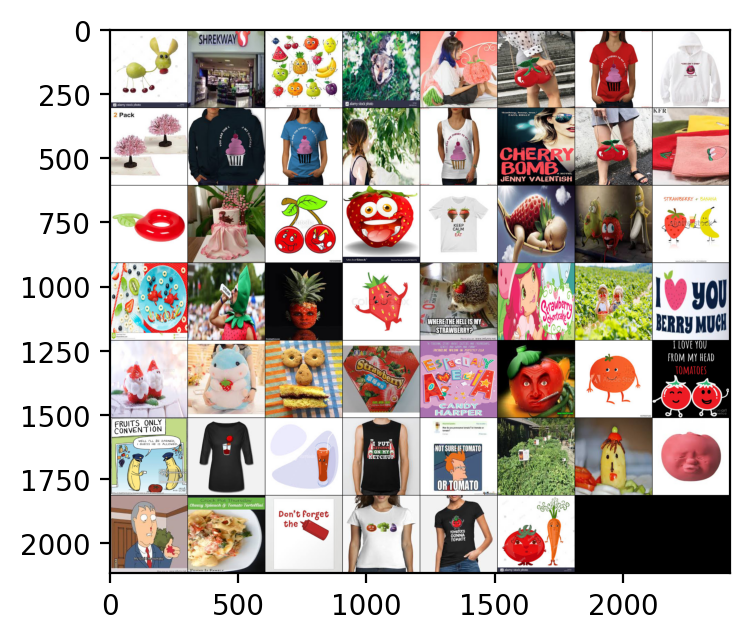

In [4]:
mydataset = ImageFolder("traindata/")
badidx = [i for i in range(len(mydataset)) if Image.open(mydataset.imgs[i][0]).size != (300, 300) ]
mydataset = ImageFolder("traindata/",transform=transforms.Compose([transforms.Resize(size=[300,300]),transforms.ToTensor()]))
badsubset = Subset(mydataset, badidx)

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

dataiter = iter(DataLoader(badsubset,batch_size=64))
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

Hm... doesn't really look like we would want to have these images in our training dataset anyways... they are a bit atypical. Let's compare with the ones that have standard dimensions of 300x300.

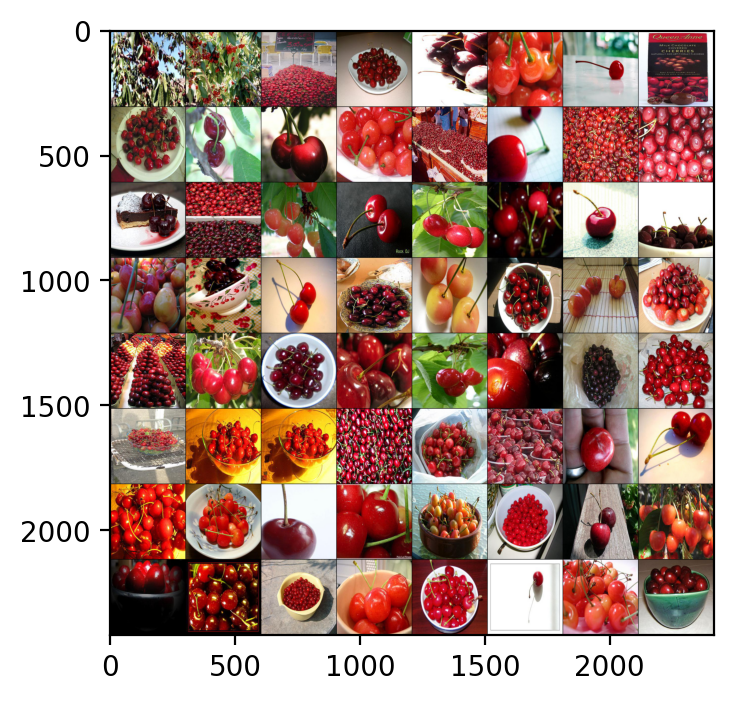

In [5]:
goodidx = [i for i in range(len(mydataset)) if Image.open(mydataset.imgs[i][0]).size == (300, 300) ]
mydataset = ImageFolder("traindata/",transform=transforms.ToTensor())
goodsubset = Subset(mydataset, goodidx)

dataiter = iter(DataLoader(goodsubset,batch_size=64))
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))


Yes... it seems those are the real deal. So maybe best to stick to these pictures and collectively discard the others as "too noisy" outliers. Let's quickly check as well if the classes are balanced.

In [6]:
train_classes = [label for _, label in goodsubset]
print(collections.Counter(train_classes))
train_classes = [label for _, label in badsubset]
print(collections.Counter(train_classes))


Counter({2: 1386, 1: 1380, 0: 1375})
Counter({0: 19, 1: 18, 2: 17})


looks roughly balanced to me.

Defining the image augmentations. Deterministically flipping images horizontally, vertically and both and then adding each of these images sets to the original dataset.
All of these are then subjected to random transformations (scaling, rotation) and then added to the previous data set. So we should end up with roughly an eightfold increase in training data.
The image normalisation (mymean and mystd) is taken from prior research done by the image classification community (c.f. orgigin of these values here https://github.com/pytorch/vision/pull/1965)

In [7]:
mymean=[0.485, 0.456, 0.406]
mystd=[0.229, 0.224, 0.225]
    
traintransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mymean,std=mystd)])
rtraintransform = transforms.Compose([transforms.RandomResizedCrop(size=300, scale=(0.8, 1.0)), transforms.RandomRotation(degrees=15),
                                      transforms.CenterCrop(size=300), transforms.ToTensor(), 
                                      transforms.Normalize(mean=mymean,std=mystd)])

vftraintransform = copy.deepcopy(traintransform)
vftraintransform.transforms.insert(0,transforms.RandomVerticalFlip(p=1))
hftraintransform = copy.deepcopy(traintransform)
hftraintransform.transforms.insert(0,transforms.RandomHorizontalFlip(p=1))
vhftraintransform = copy.deepcopy(traintransform)
vhftraintransform.transforms.insert(0,transforms.RandomHorizontalFlip(p=1))
vhftraintransform.transforms.insert(0,transforms.RandomVerticalFlip(p=1))
rvftraintransform = copy.deepcopy(rtraintransform)
rvftraintransform.transforms.insert(0,transforms.RandomVerticalFlip(p=1))
rhftraintransform = copy.deepcopy(rtraintransform)
rhftraintransform.transforms.insert(0,transforms.RandomHorizontalFlip(p=1))
rvhftraintransform = copy.deepcopy(rtraintransform)
rvhftraintransform.transforms.insert(0,transforms.RandomHorizontalFlip(p=1))
rvhftraintransform.transforms.insert(0,transforms.RandomVerticalFlip(p=1))


Next thing we need we exclude the bad/noisy pictures (using goodidx to create a Subset). Then we need load all the data and split it in training and validation set. Things got a bit tricky with image augmentation and training/validation split. You can define just random transformation which will kick in (in the training and validation data set) at random during various epochs. The advantage is that training and validation images remain strictly separated. But I found this approach to not perform as good as when you create a whole new training data set where all sorts of transformations are applied deterministically as well as some at random (as we have done above). The problem with that approach is that in the normal workflow the split into training and validation data set occurs AFTER the creation of the augmented dataset (inside the DataLoader). This leads to heavy contamination of the validation dataset, e.g. if an image that exists in the training data set is being rotated by one degree and then ends up in the validation data set. Hence manually made sure that the split of the images into training images and validation images carries forward even after transformations and augmentations are applied. I also decided to NOT included any transformed images into the validation dataset, to make sure that data set is as close to a real test set one would encounter "in the wild"

In [8]:
batch_size = 8

trainset = Subset(ImageFolder('traindata/',transform=traintransform), goodidx)
vftrainset = Subset(ImageFolder('traindata/', transform=vftraintransform), goodidx)
hftrainset = Subset(ImageFolder('traindata/', transform=hftraintransform), goodidx)
vfhftrainset = Subset(ImageFolder('traindata/', transform=vhftraintransform), goodidx)
rtrainset = Subset(ImageFolder('traindata/',transform=traintransform), goodidx)
rvftrainset = Subset(ImageFolder('traindata/', transform=rvftraintransform), goodidx)
rhftrainset = Subset(ImageFolder('traindata/', transform=rhftraintransform), goodidx)
rvfhftrainset = Subset(ImageFolder('traindata/', transform=rvhftraintransform), goodidx)
increased_dataset = torch.utils.data.ConcatDataset([trainset,vftrainset,hftrainset,vfhftrainset,rtrainset,rvftrainset,rhftrainset,rvfhftrainset])

#increased_dataset = torch.utils.data.ConcatDataset([trainset])

num_train = len(trainset)

y = np.array([label for _, label in goodsubset])
X = list(range(num_train))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

train_idx, valid_idx = next(sss.split(X, y))

new_list1 = train_idx+num_train
new_list2 = train_idx+2*num_train
new_list3 = train_idx+3*num_train
new_list4 = train_idx+4*num_train
new_list5 = train_idx+5*num_train
new_list6 = train_idx+6*num_train
new_list7 = train_idx+7*num_train

train_idx= np.concatenate((train_idx,new_list1,new_list2,new_list3,new_list4,new_list5,new_list6,new_list7))

print('len(train_idx) ==> ', len(train_idx))
print('len(valid_idx) ==> ', len(valid_idx))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
classes = ('cherry', 'strawberry', 'tomato')



len(train_idx) ==>  26496
len(valid_idx) ==>  829


In [9]:
trainloader = DataLoader(increased_dataset, sampler=train_sampler, batch_size=batch_size, shuffle=False,pin_memory=True)
valloader = DataLoader(increased_dataset, sampler=valid_sampler, batch_size=batch_size, shuffle=False,pin_memory=True)


We can see, we ended up with 26k training images and roughly 800 validation images. Quickly making sure as well that I din't stuff anything up... particularly that the class labels all match with the images. Just checking that the class distribution is balanced in both indices. I stuffed that up before by not using stratified sampling.

In [10]:
train_classes = [label for _, label in Subset(goodsubset,train_idx)]
print(collections.Counter(train_classes))
train_classes = [label for _, label in Subset(goodsubset,valid_idx)]
print(collections.Counter(train_classes))


Counter({2: 1108, 1: 1104, 0: 1100})
Counter({2: 278, 1: 276, 0: 275})


looks good.. classes are balanced in both training as well as validation data set (indices)

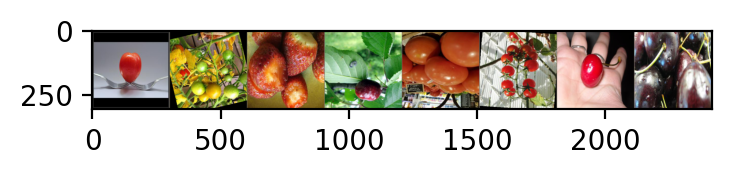

tomato tomato strawberry cherry tomato tomato cherry cherry


In [11]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = mystd * img + mymean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


looking good... moving on to define training function with the help of poutyne

In [12]:
def better_poutyne_train(model_name, pytorch_model,plr=0.0001):
    plotlosses = PlotLossesPoutyne()
    callbacks = [
        # Save the latest weights 
        ModelCheckpoint(model_name + '_last_epoch.ckpt',temporary_filename='last_epoch.ckpt.tmp'),
        # EarlyStopping
        EarlyStopping(monitor='val_acc', patience=3, verbose=True, mode='max'),
        plotlosses,
        BestModelRestore(monitor='val_acc', mode='max')
    ]
    
    # Select the optimizer and the loss function 
    optimizer = optim.Adam(pytorch_model.parameters(), lr=plr)
    #optimizer = optim.SGD(pytorch_model.parameters(), lr=0.001, momentum=0.9)
    loss_function = nn.CrossEntropyLoss()
    # Poutyne Model
    model = Model(pytorch_model, optimizer, loss_function, batch_metrics=['accuracy'])
    # Send the 'Poutyne model' on GPU/CPU whichever is available 
    model.to(device)
    # Train

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
  
    model.fit_generator(trainloader, valloader, epochs=epochs, callbacks=callbacks)
    end.record()
    # Waits for everything to finish running
    torch.cuda.synchronize()
    
    print("training time in minutes: ")
    print(start.elapsed_time(end)/60000)

    # Test
    val_loss, val_acc, pred_y, true_y = model.evaluate_generator(valloader,return_pred=True,return_ground_truth=True)
    #print(f'Test:\n\tLoss: {val_loss: .3f}\n\tAccuracy: {val_acc: .3f}')

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_y, pred_y.argmax(axis=1),normalize='true'),display_labels=classes).plot()
    plt.show()

    return None

Defining a plain vanilla feed forward neural network as benchmark.

In [16]:
class PlainVanilla(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*300*300,255)
        self.fc2 = nn.Linear(255,3)

    def forward(self, x):
        x = F.relu(self.fc1(torch.flatten(x, 1)))
        x = self.fc2(x)
        return x
PVnet = PlainVanilla().to(device)

summary(model=PVnet, input_size=(3,300*300), batch_size=batch_size) 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [8, 255]      68,850,255
            Linear-2                     [8, 3]             768
Total params: 68,851,023
Trainable params: 68,851,023
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 8.24
Forward/backward pass size (MB): 0.02
Params size (MB): 262.65
Estimated Total Size (MB): 270.90
----------------------------------------------------------------


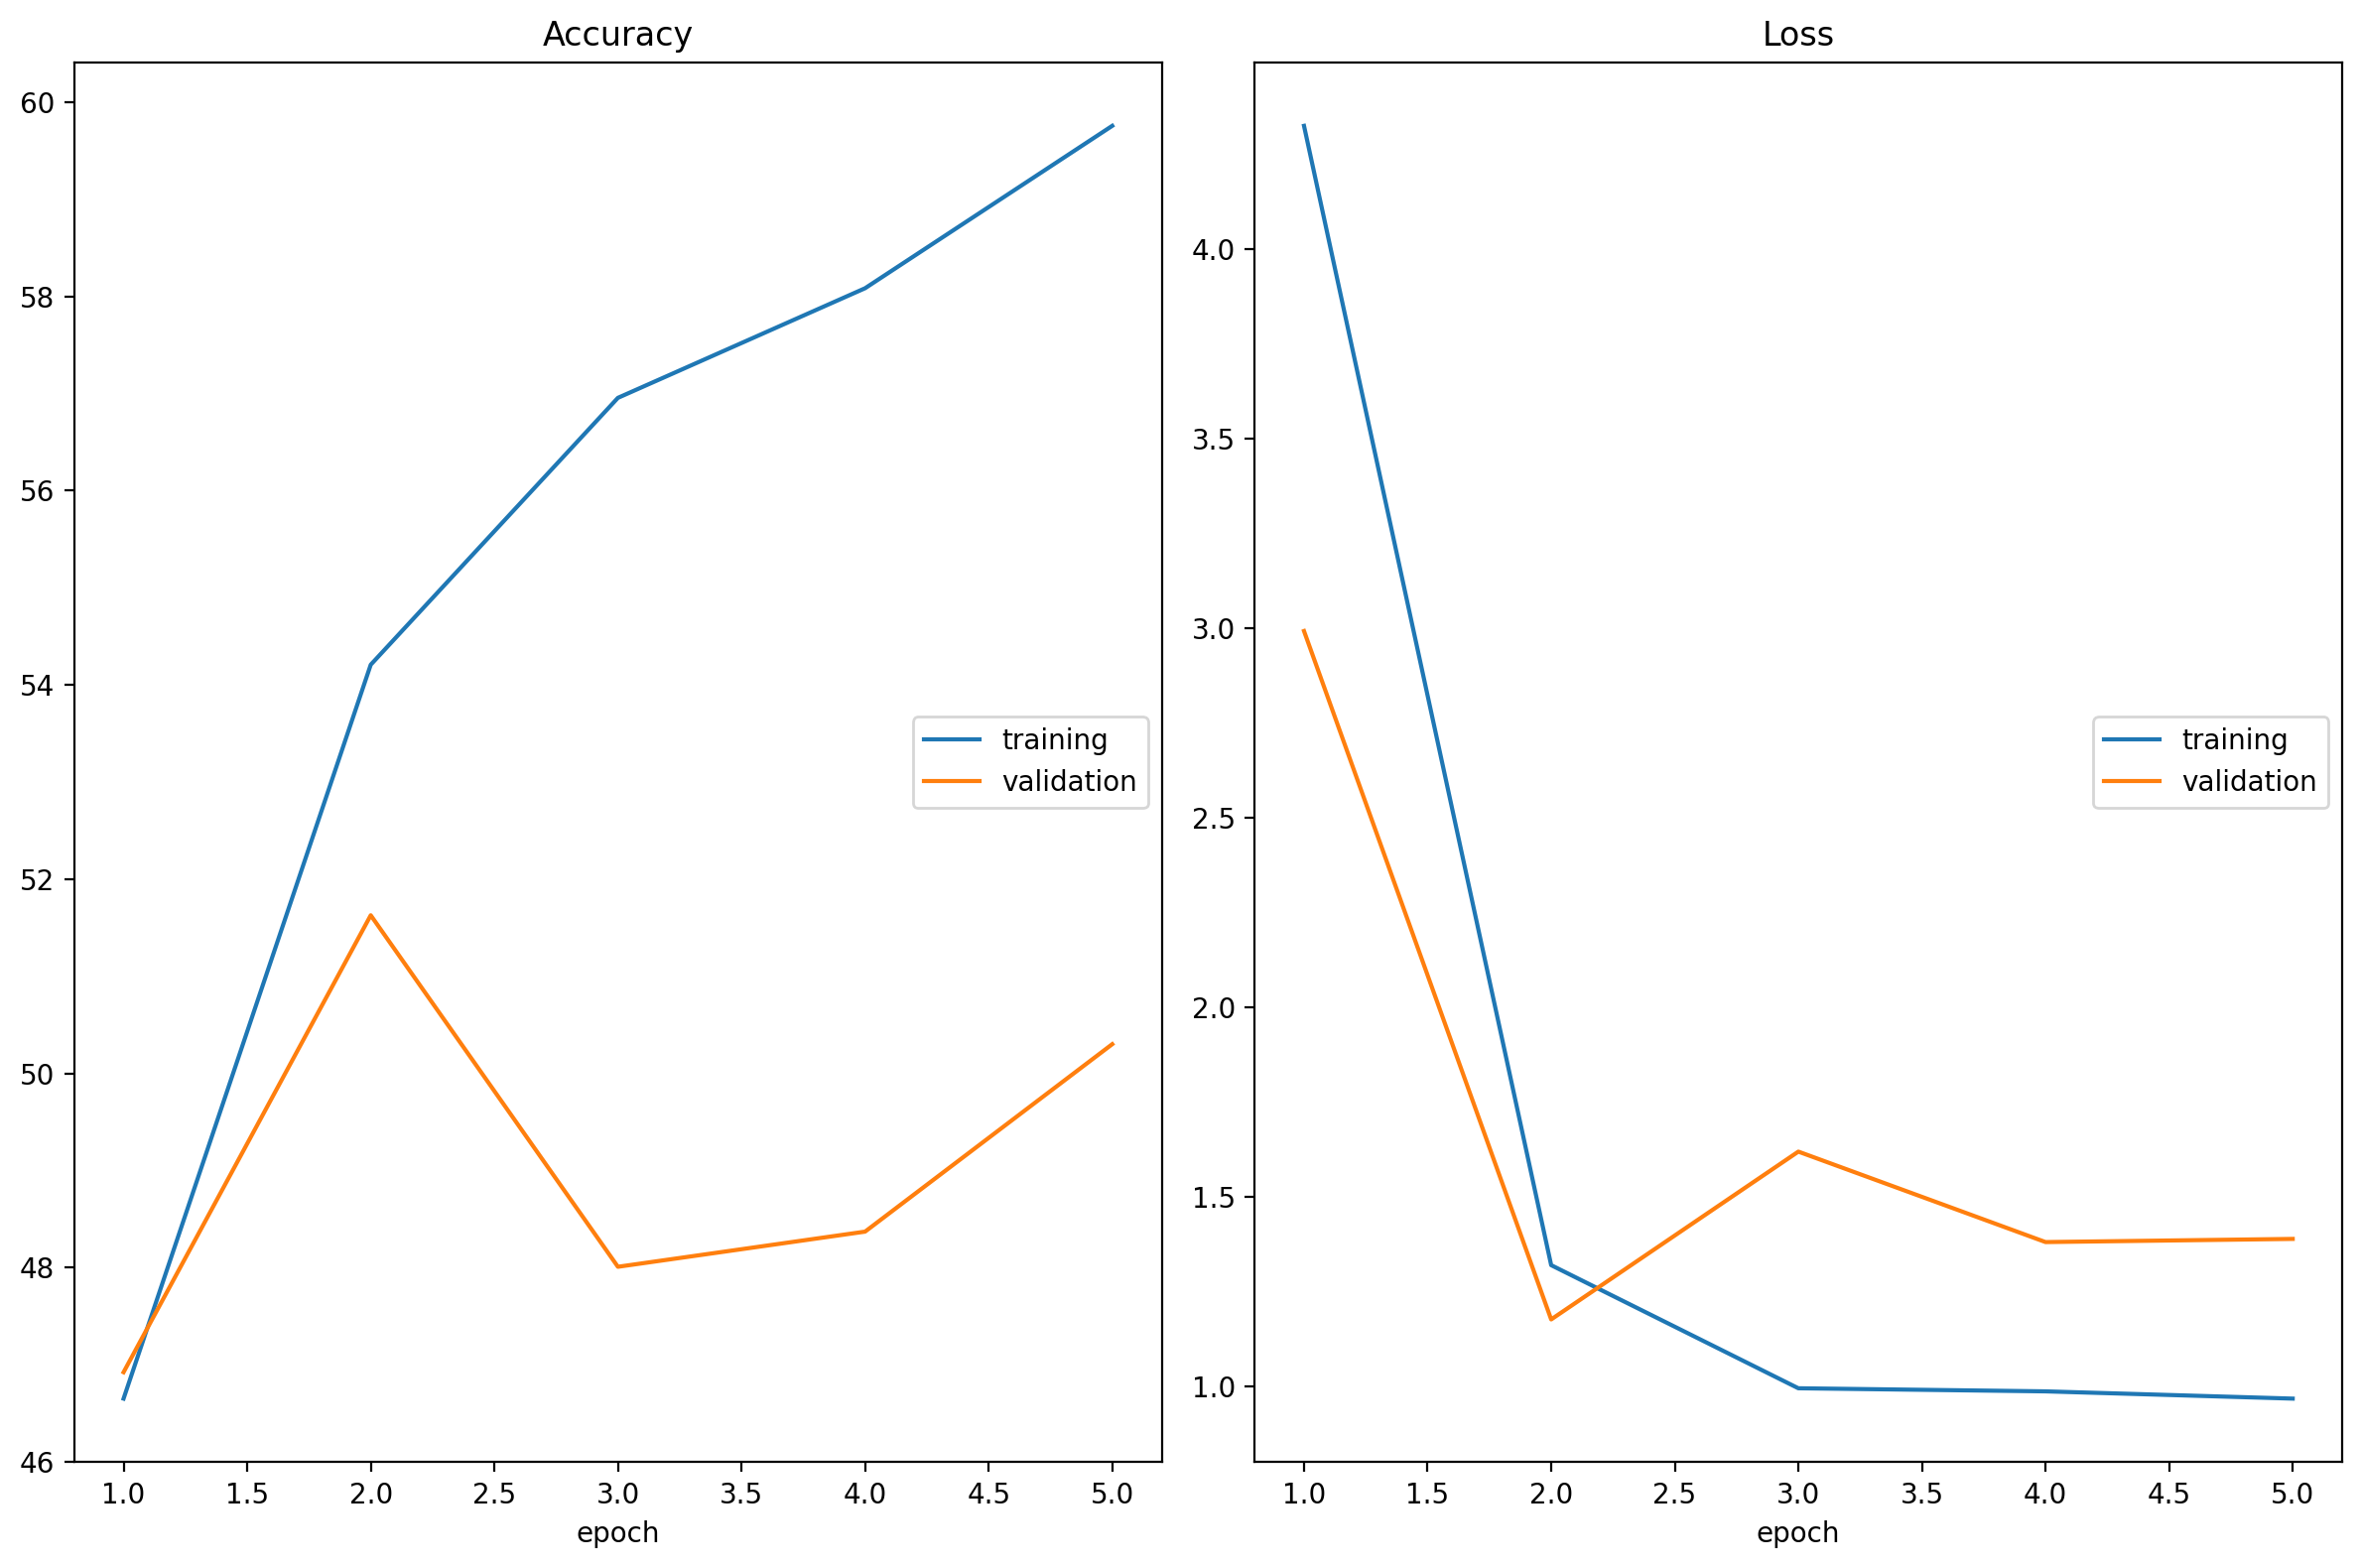

Accuracy
	training         	 (min:   46.652, max:   59.756, cur:   59.756)
	validation       	 (min:   46.924, max:   51.628, cur:   50.302)
Loss
	training         	 (min:    0.968, max:    4.325, cur:    0.968)
	validation       	 (min:    1.176, max:    2.992, cur:    1.389)
training time in minutes: 
16.83354375
Test steps: 104 2.39s test_loss: 1.176487 test_acc: 51.628468                                                 


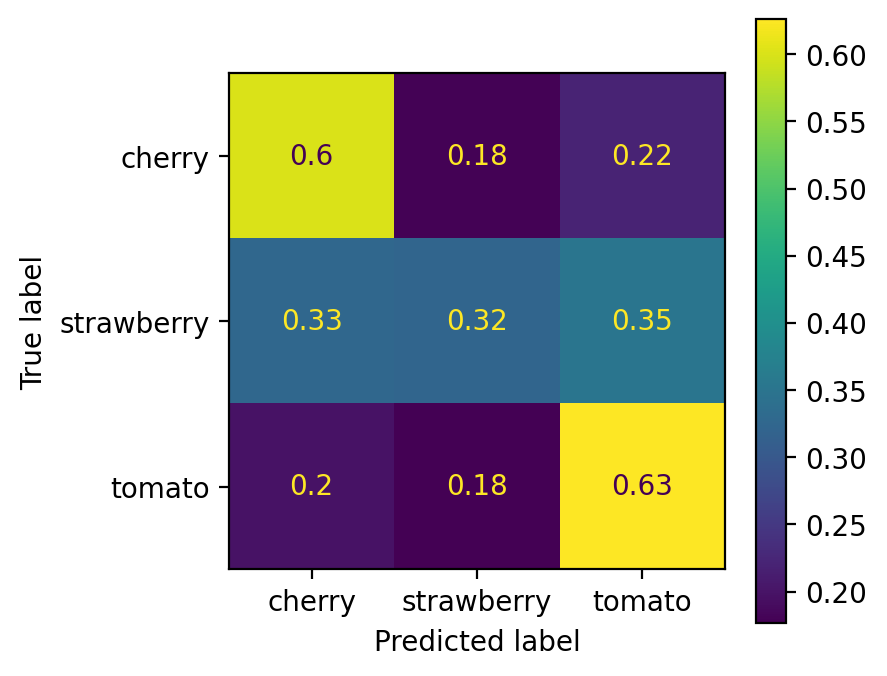

In [17]:
epochs=10
better_poutyne_train("trial0",PVnet)


In [14]:
PATH = './PV.pth'
torch.save(PVnet.state_dict(), PATH)

In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 72 * 72, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(self.pool(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
net = Net().to(device)

summary(model=net, input_size=(3, 300, 300), batch_size=batch_size) 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [8, 6, 296, 296]             456
         MaxPool2d-2           [8, 6, 148, 148]               0
            Conv2d-3          [8, 16, 144, 144]           2,416
         MaxPool2d-4            [8, 16, 72, 72]               0
           Dropout-5            [8, 16, 72, 72]               0
            Linear-6                   [8, 120]       9,953,400
            Linear-7                    [8, 84]          10,164
           Dropout-8                    [8, 84]               0
            Linear-9                     [8, 3]             255
Total params: 9,966,691
Trainable params: 9,966,691
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 8.24
Forward/backward pass size (MB): 70.50
Params size (MB): 38.02
Estimated Total Size (MB): 116.76
-----------------------------------

In [23]:
PATHempty = './myownempty.pth'
torch.save(net.state_dict(), PATHempty)


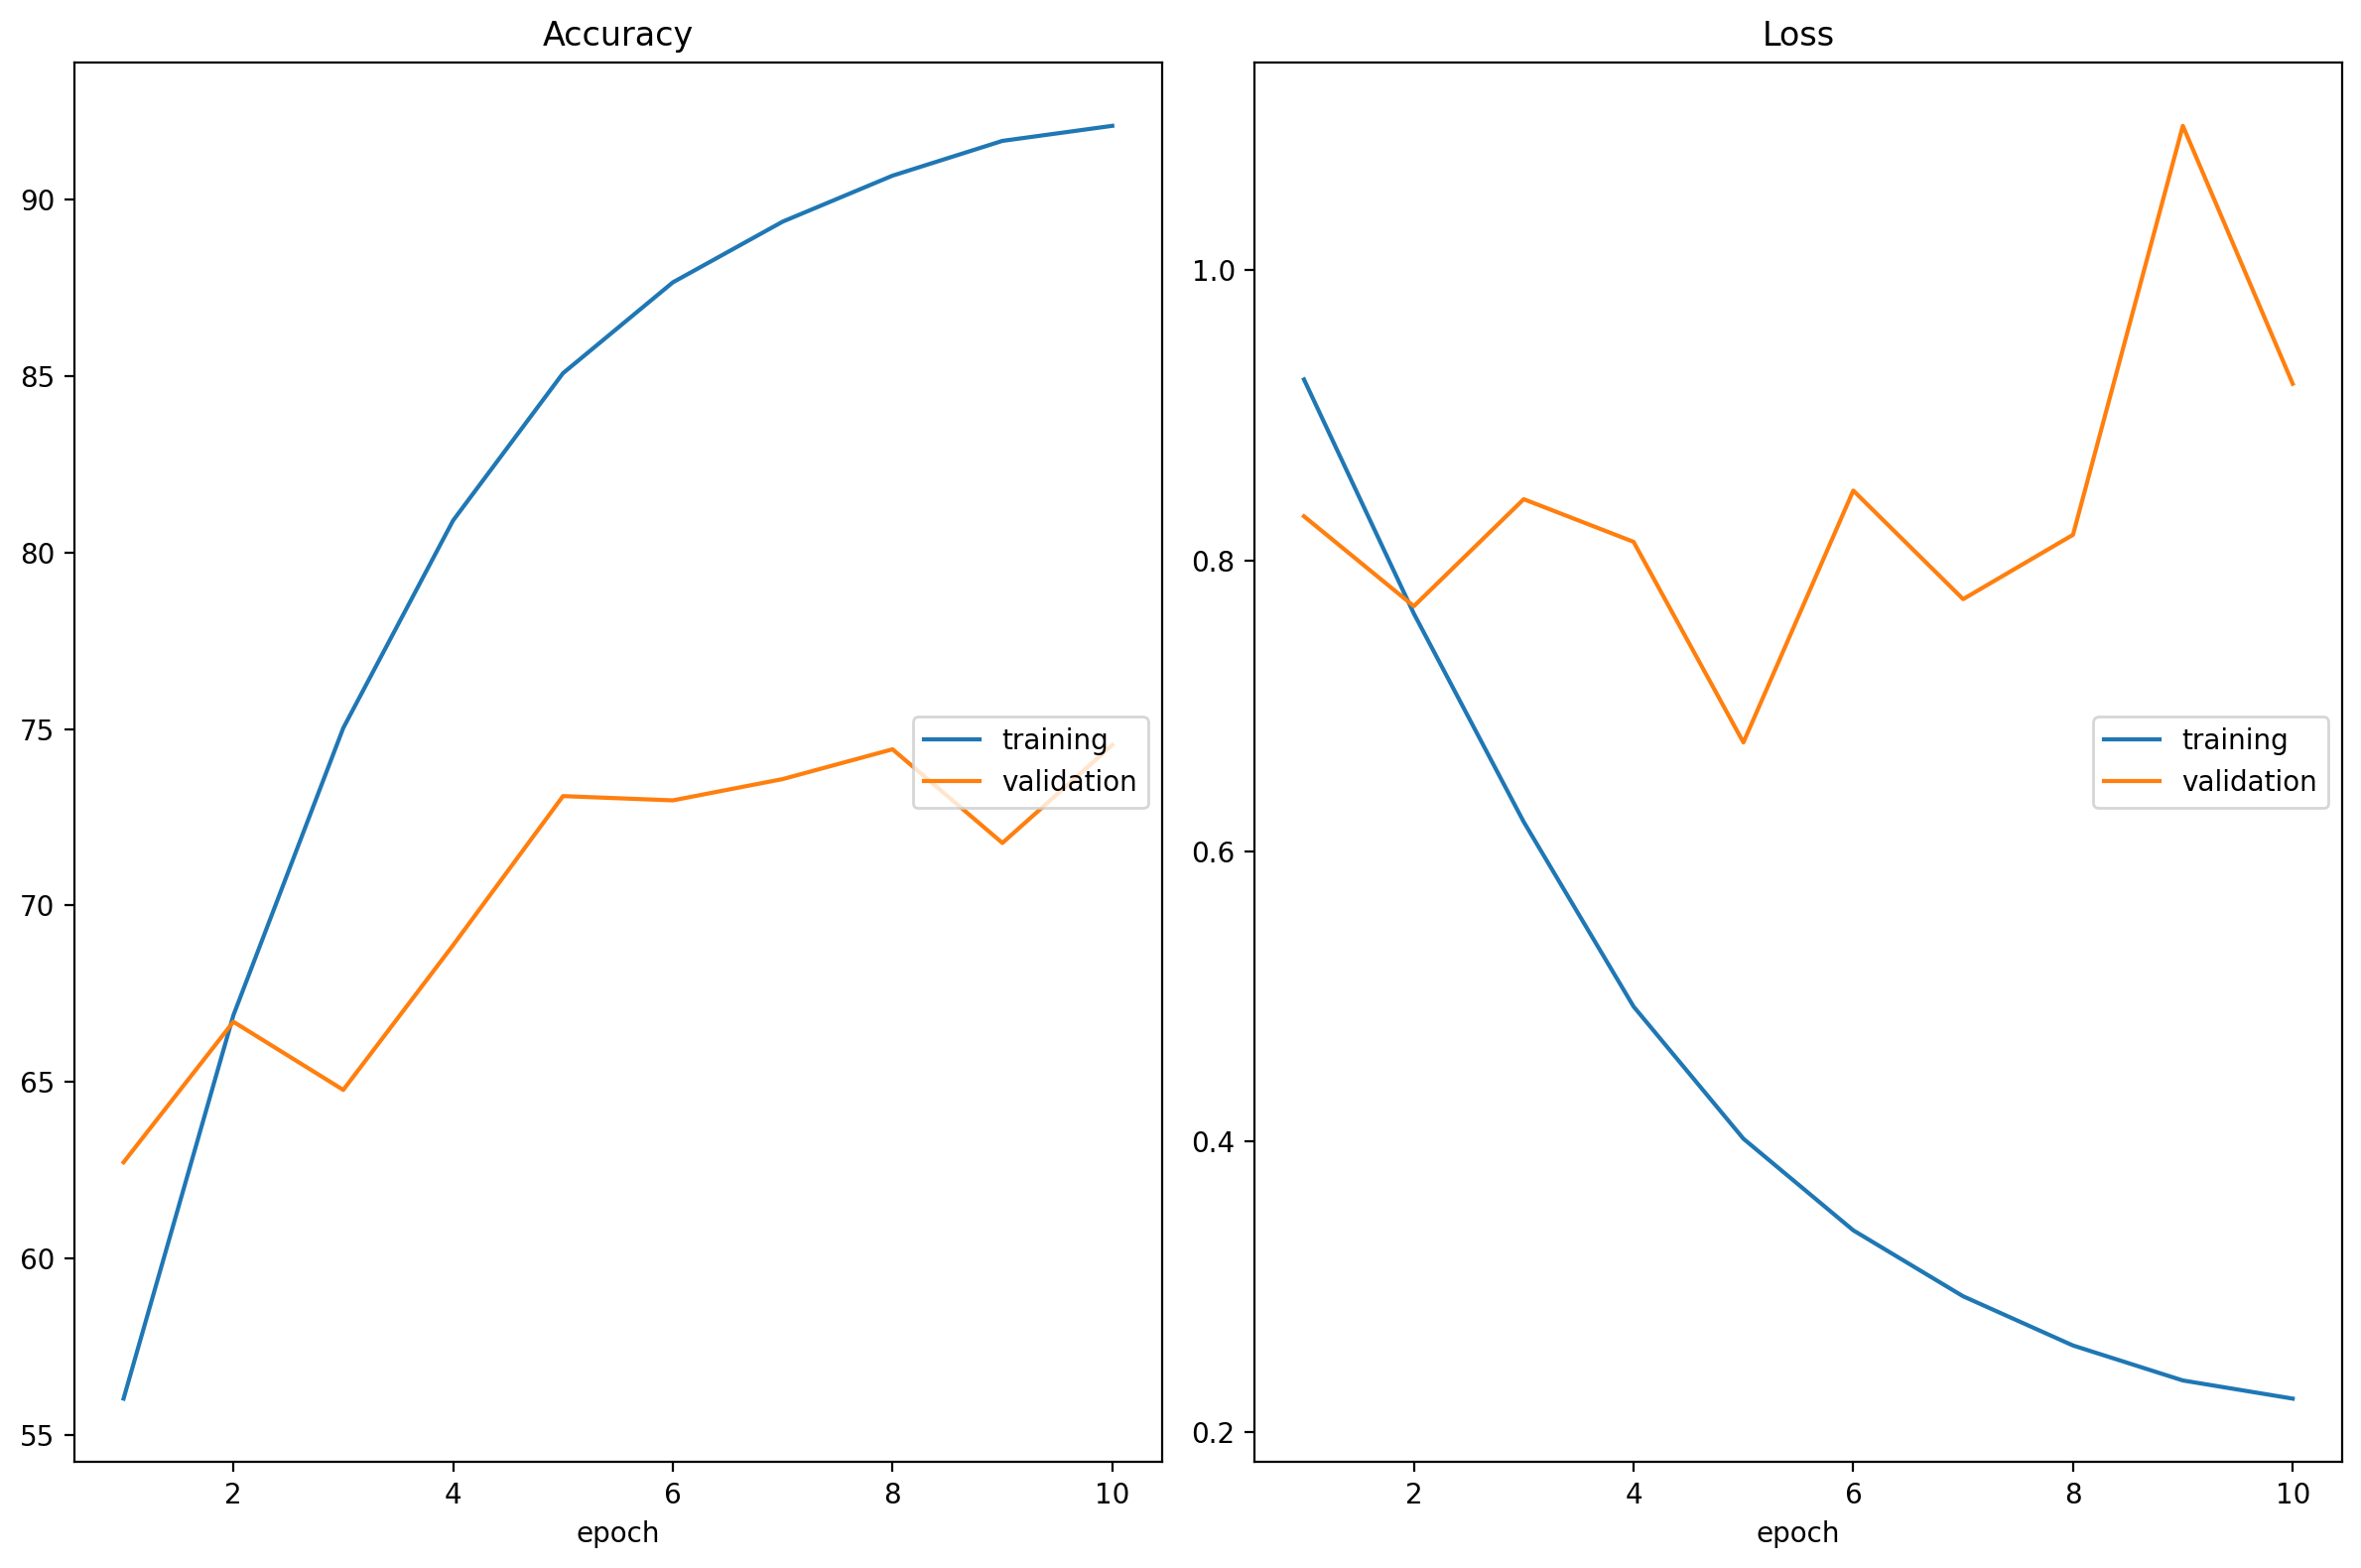

Accuracy
	training         	 (min:   56.031, max:   92.089, cur:   92.089)
	validation       	 (min:   62.726, max:   74.548, cur:   74.548)
Loss
	training         	 (min:    0.223, max:    0.925, cur:    0.223)
	validation       	 (min:    0.675, max:    1.099, cur:    0.922)
training time in minutes: 
21.677545833333333
Test steps: 104 2.32s test_loss: 0.921661 test_acc: 74.547648                                                  


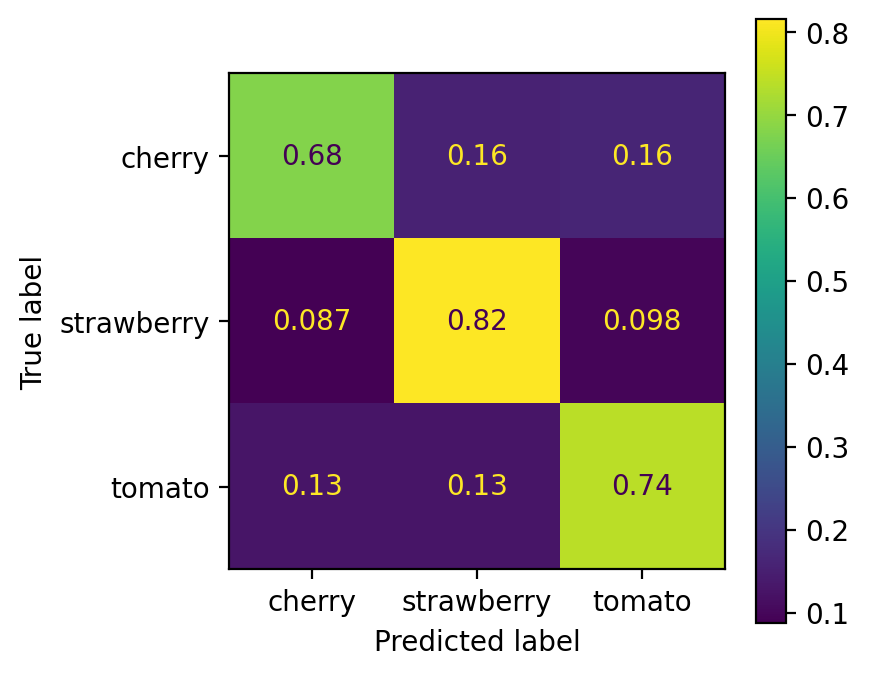

In [24]:

epochs=10
better_poutyne_train("trial1",net)


In [25]:
PATH = './myown.pth'
torch.save(net.state_dict(), PATH)

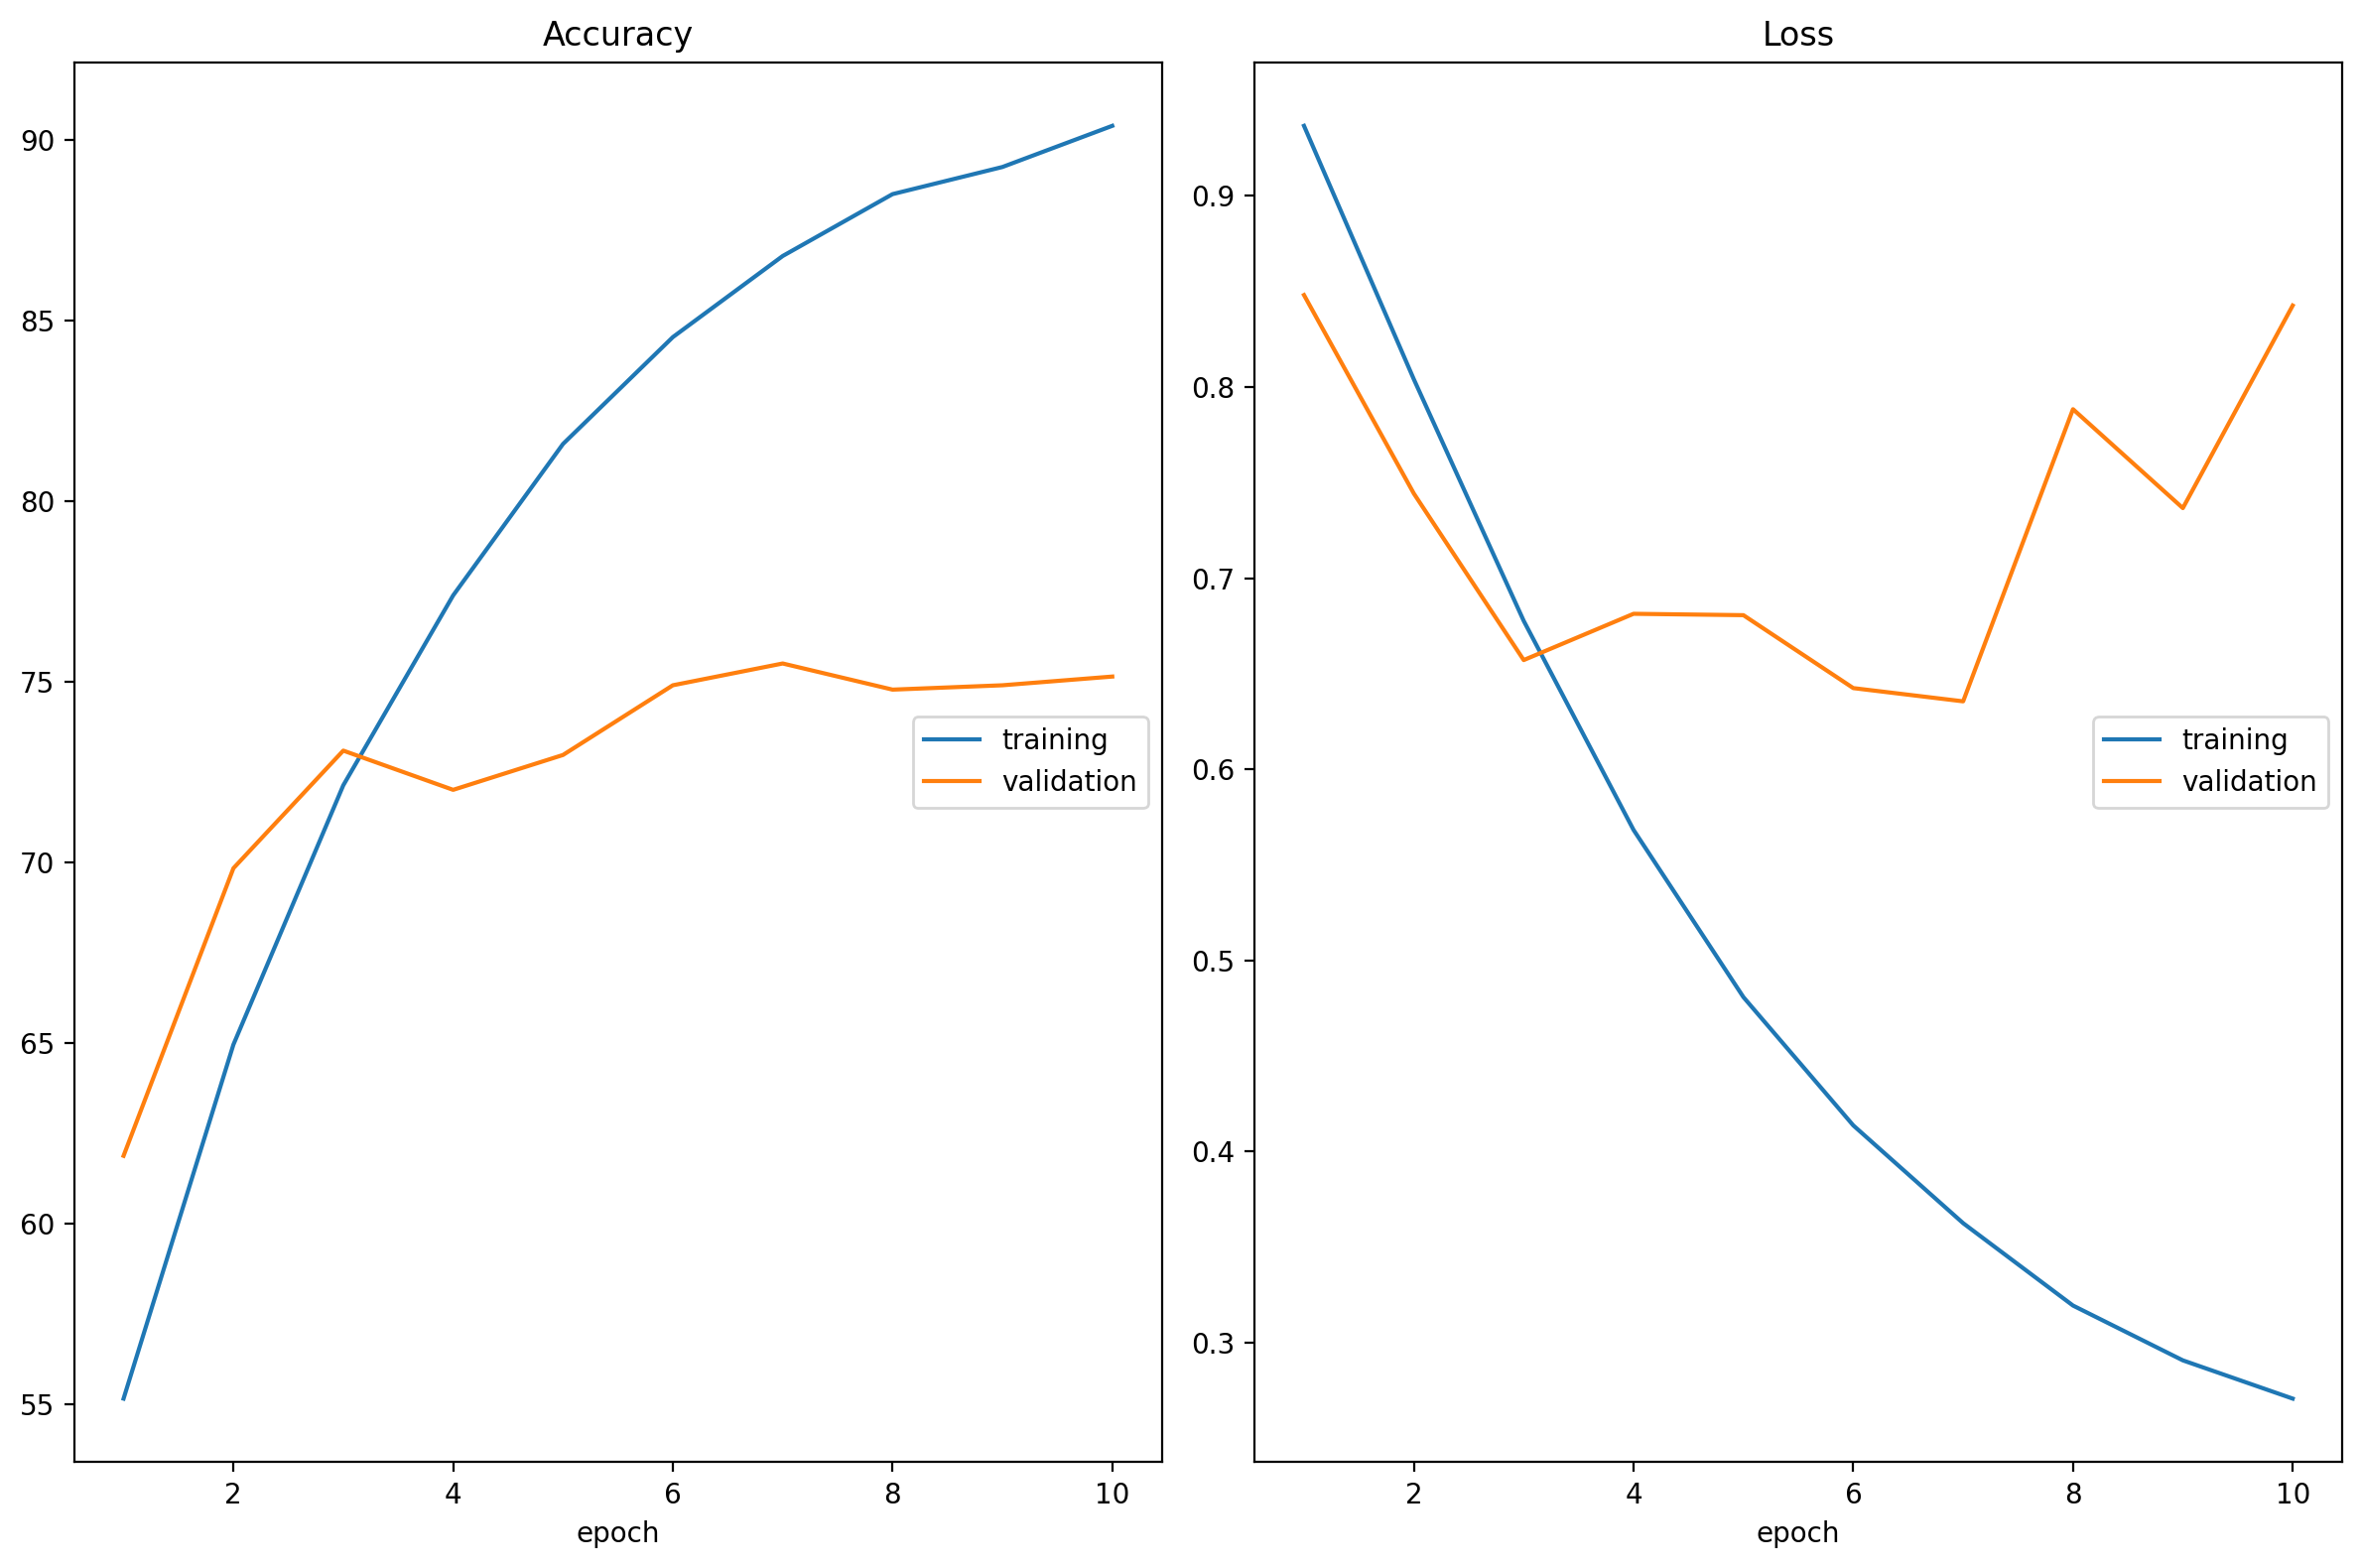

Accuracy
	training         	 (min:   55.159, max:   90.399, cur:   90.399)
	validation       	 (min:   61.882, max:   75.513, cur:   75.151)
Loss
	training         	 (min:    0.271, max:    0.937, cur:    0.271)
	validation       	 (min:    0.636, max:    0.848, cur:    0.843)
training time in minutes: 
21.624489583333332
Test steps: 104 2.29s test_loss: 0.635520 test_acc: 75.512666                                                 


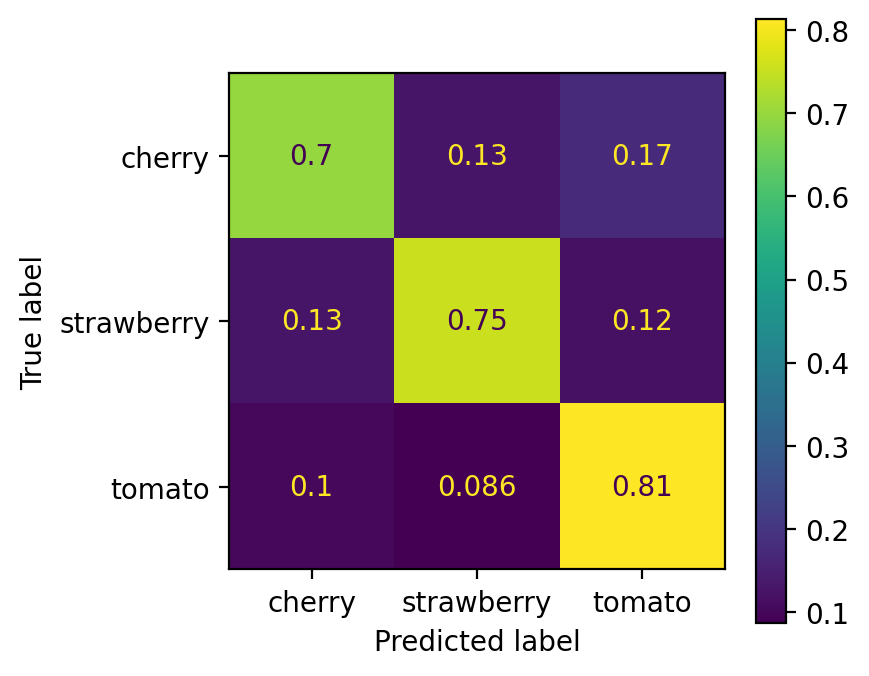

In [51]:
#net = Net().to(device)
net.load_state_dict(torch.load(PATHempty))
mynet=nn.Sequential(*list(net.children())[:3]+list(net.children())[5:])
epochs=10
trainloader = DataLoader(increased_dataset, sampler=train_sampler, batch_size=8, shuffle=False,pin_memory=True)
valloader = DataLoader(increased_dataset, sampler=valid_sampler, batch_size=8, shuffle=False,pin_memory=True)
better_poutyne_train("trial1x",net)
PATH = './myownnodropout.pth'
torch.save(net.state_dict(), PATH)


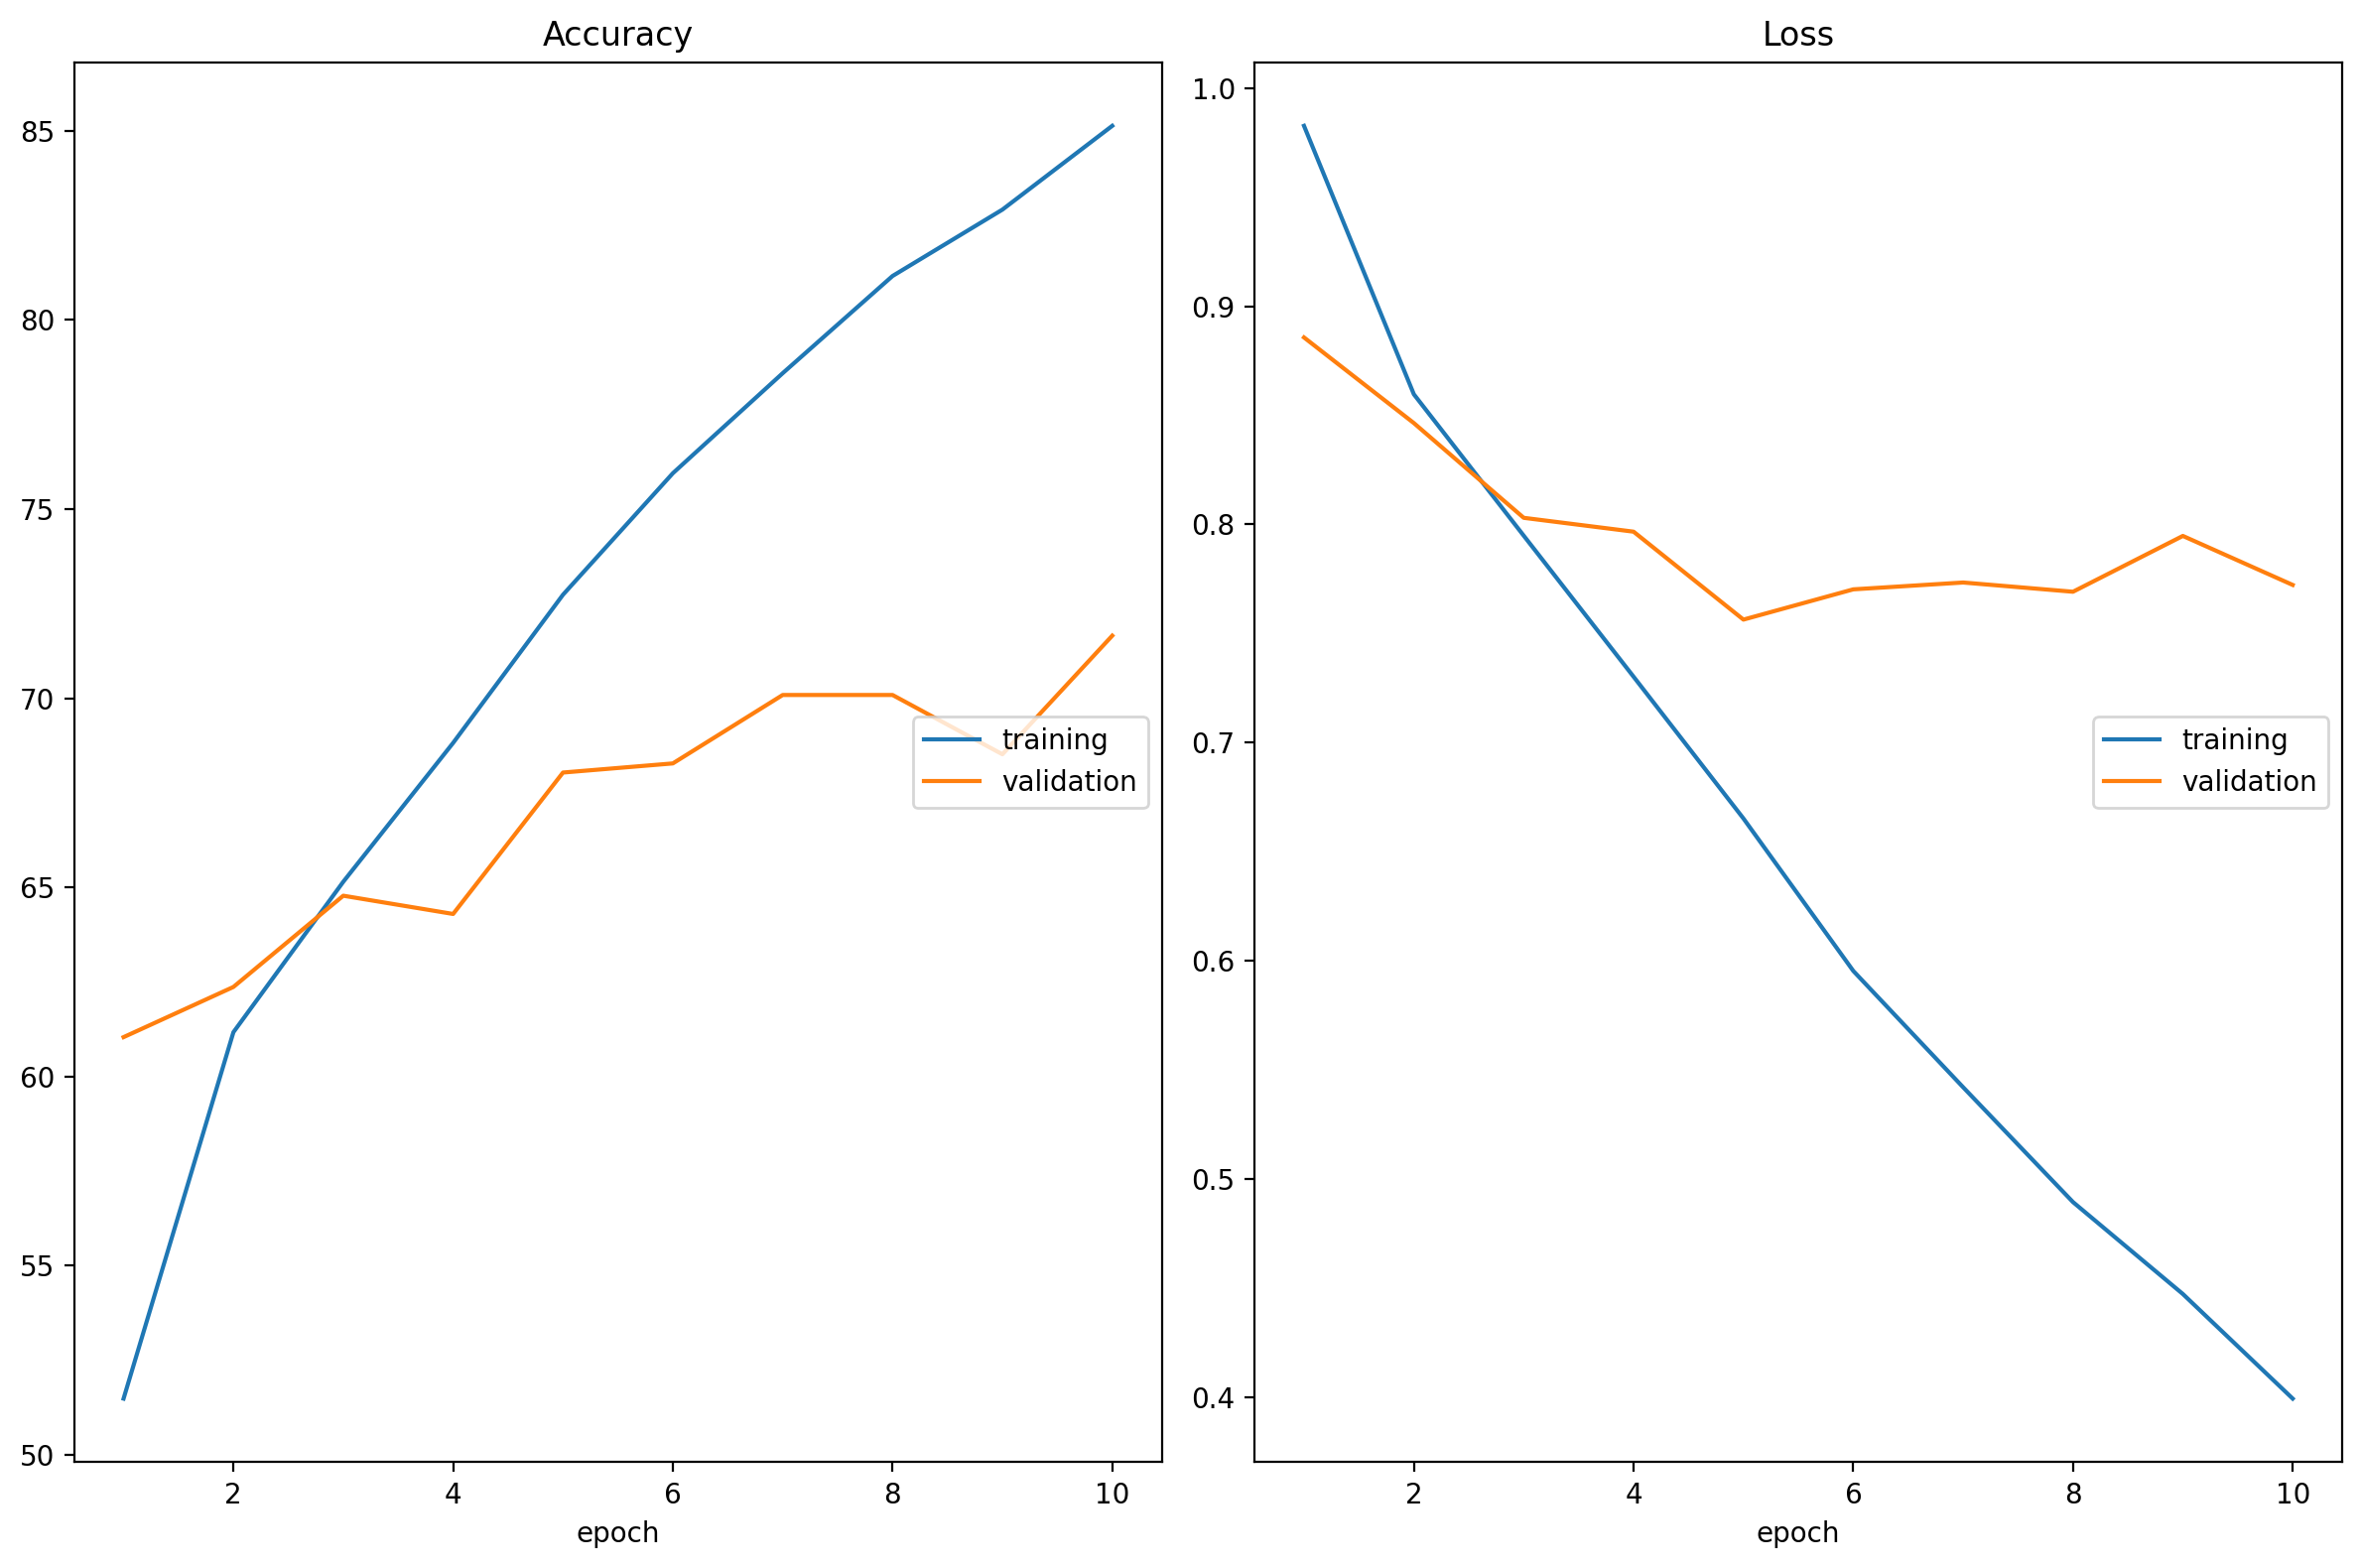

Accuracy
	training         	 (min:   51.479, max:   85.134, cur:   85.134)
	validation       	 (min:   61.037, max:   71.653, cur:   71.653)
Loss
	training         	 (min:    0.399, max:    0.983, cur:    0.399)
	validation       	 (min:    0.756, max:    0.886, cur:    0.772)
training time in minutes: 
19.789816666666667
Test steps: 13 2.46s test_loss: 0.772213 test_acc: 71.652593                                                


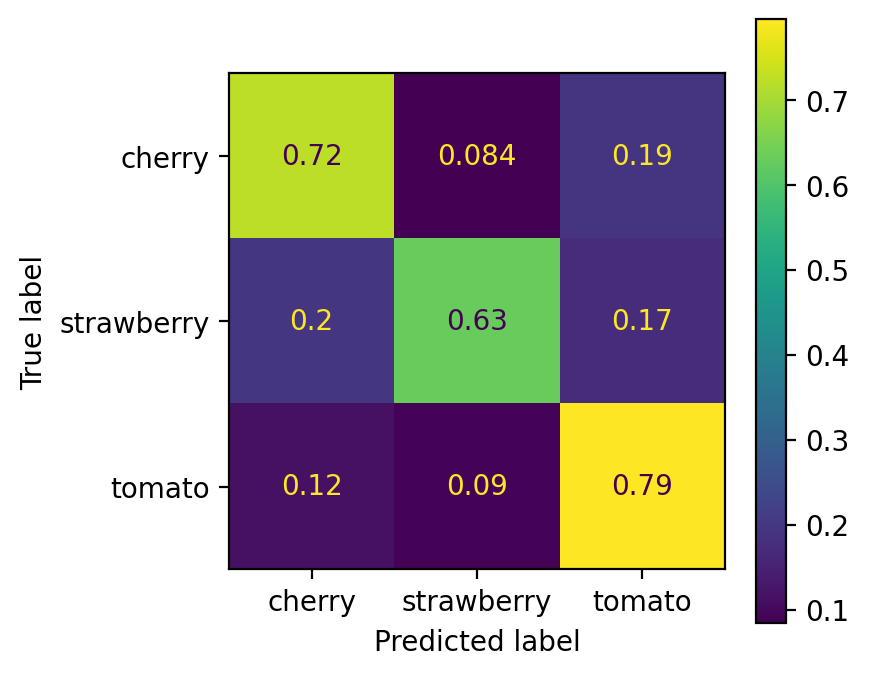

In [26]:
#net = Net().to(device)
net.load_state_dict(torch.load(PATHempty))
epochs=10
trainloader = DataLoader(increased_dataset, sampler=train_sampler, batch_size=64, shuffle=False,pin_memory=True)
valloader = DataLoader(increased_dataset, sampler=valid_sampler, batch_size=64, shuffle=False,pin_memory=True)
better_poutyne_train("trial1a",net)
PATH = './myownBZ64.pth'
torch.save(net.state_dict(), PATH)

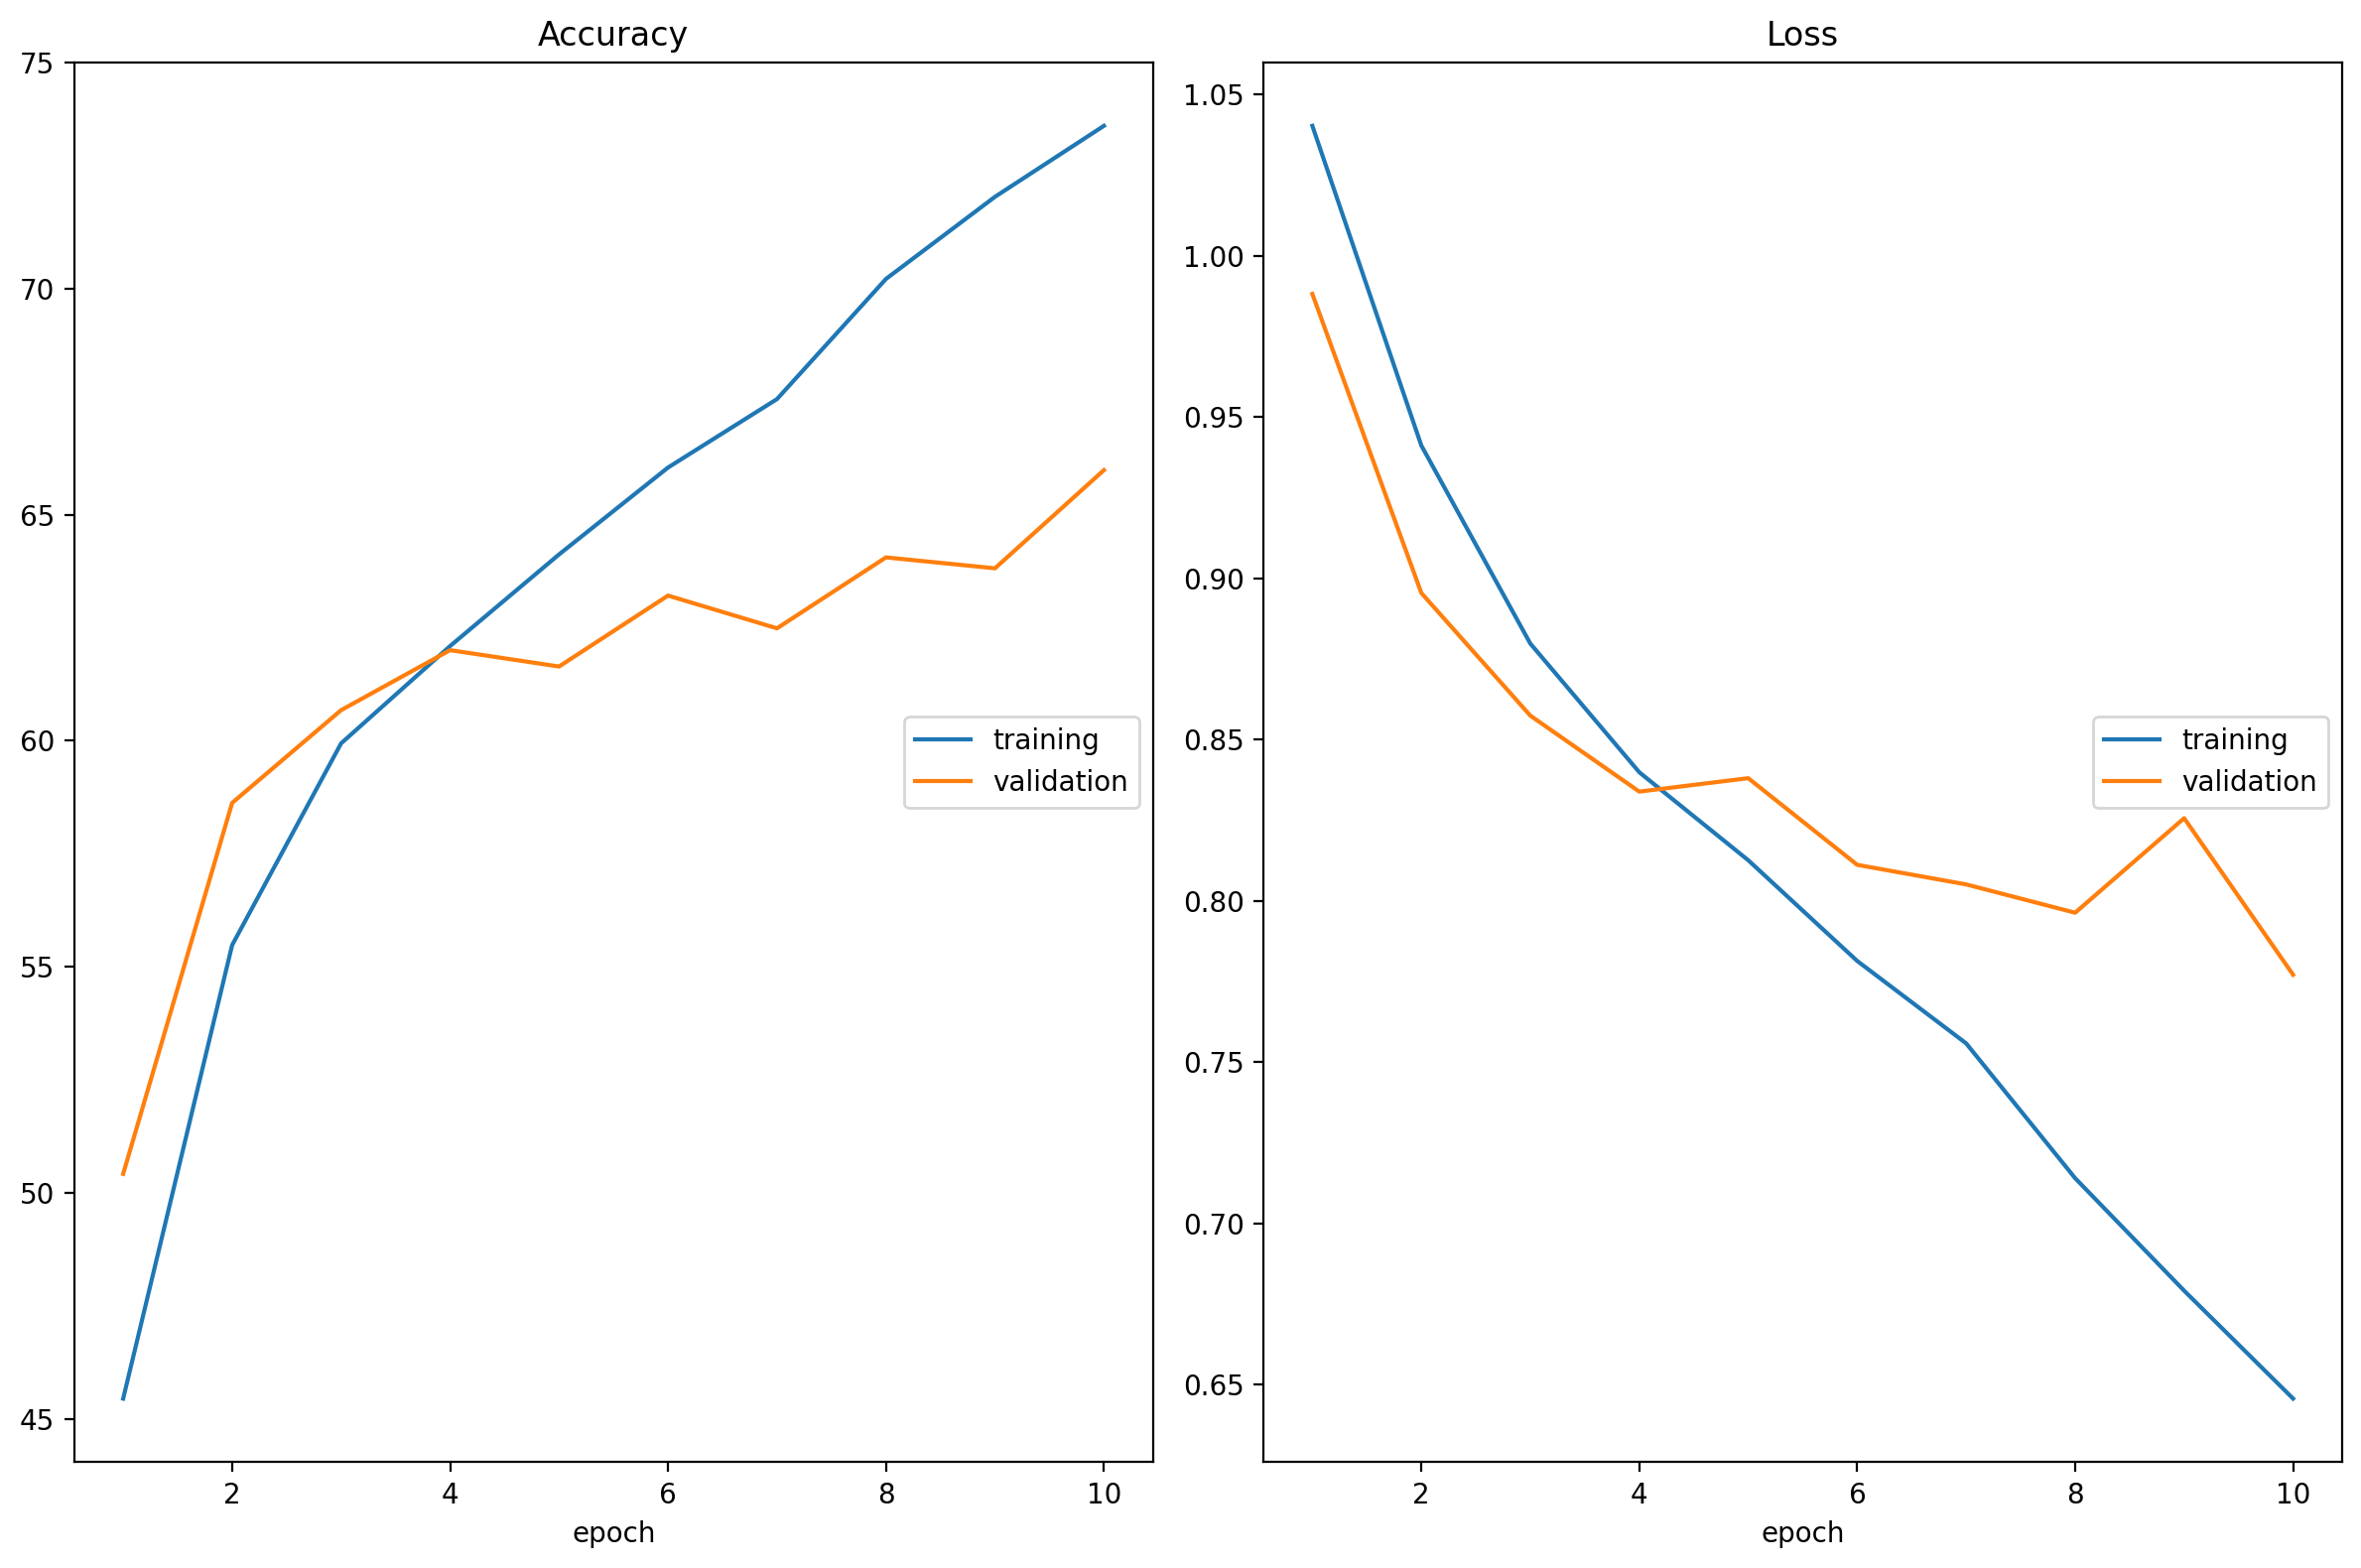

Accuracy
	training         	 (min:   45.452, max:   73.596, cur:   73.596)
	validation       	 (min:   50.422, max:   65.983, cur:   65.983)
Loss
	training         	 (min:    0.646, max:    1.040, cur:    0.646)
	validation       	 (min:    0.777, max:    0.988, cur:    0.777)
training time in minutes: 
19.635060416666665
Test steps: 4 2.48s test_loss: 0.777092 test_acc: 65.983112                                               


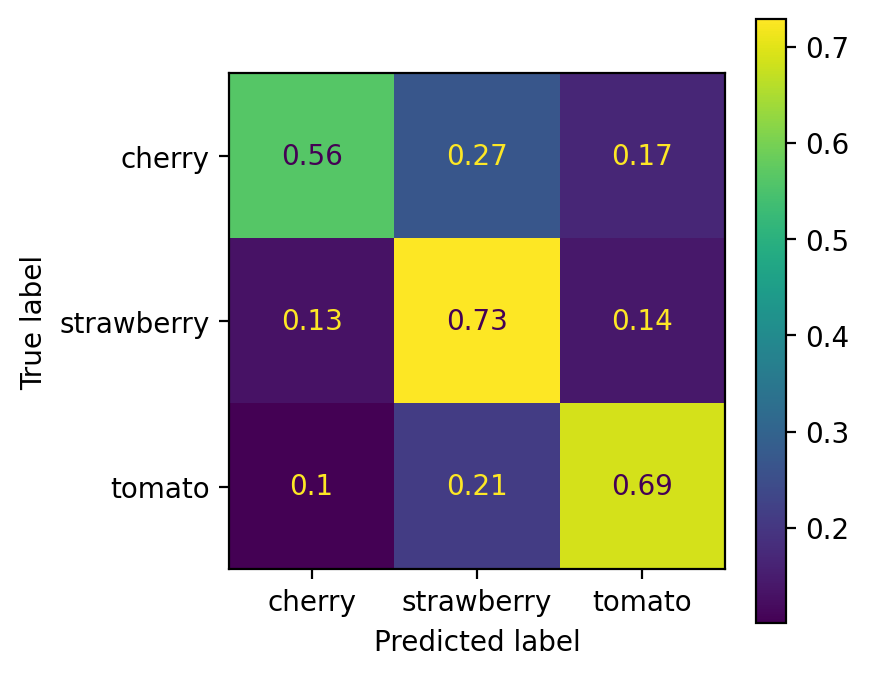

In [27]:
#net = Net().to(device)
net.load_state_dict(torch.load(PATHempty))
epochs=10
trainloader = DataLoader(increased_dataset, sampler=train_sampler, batch_size=256, shuffle=False,pin_memory=True)
valloader = DataLoader(increased_dataset, sampler=valid_sampler, batch_size=256, shuffle=False,pin_memory=True)
better_poutyne_train("trial1b",net)
PATH = './myownBZ256.pth'
torch.save(net.state_dict(), PATH)

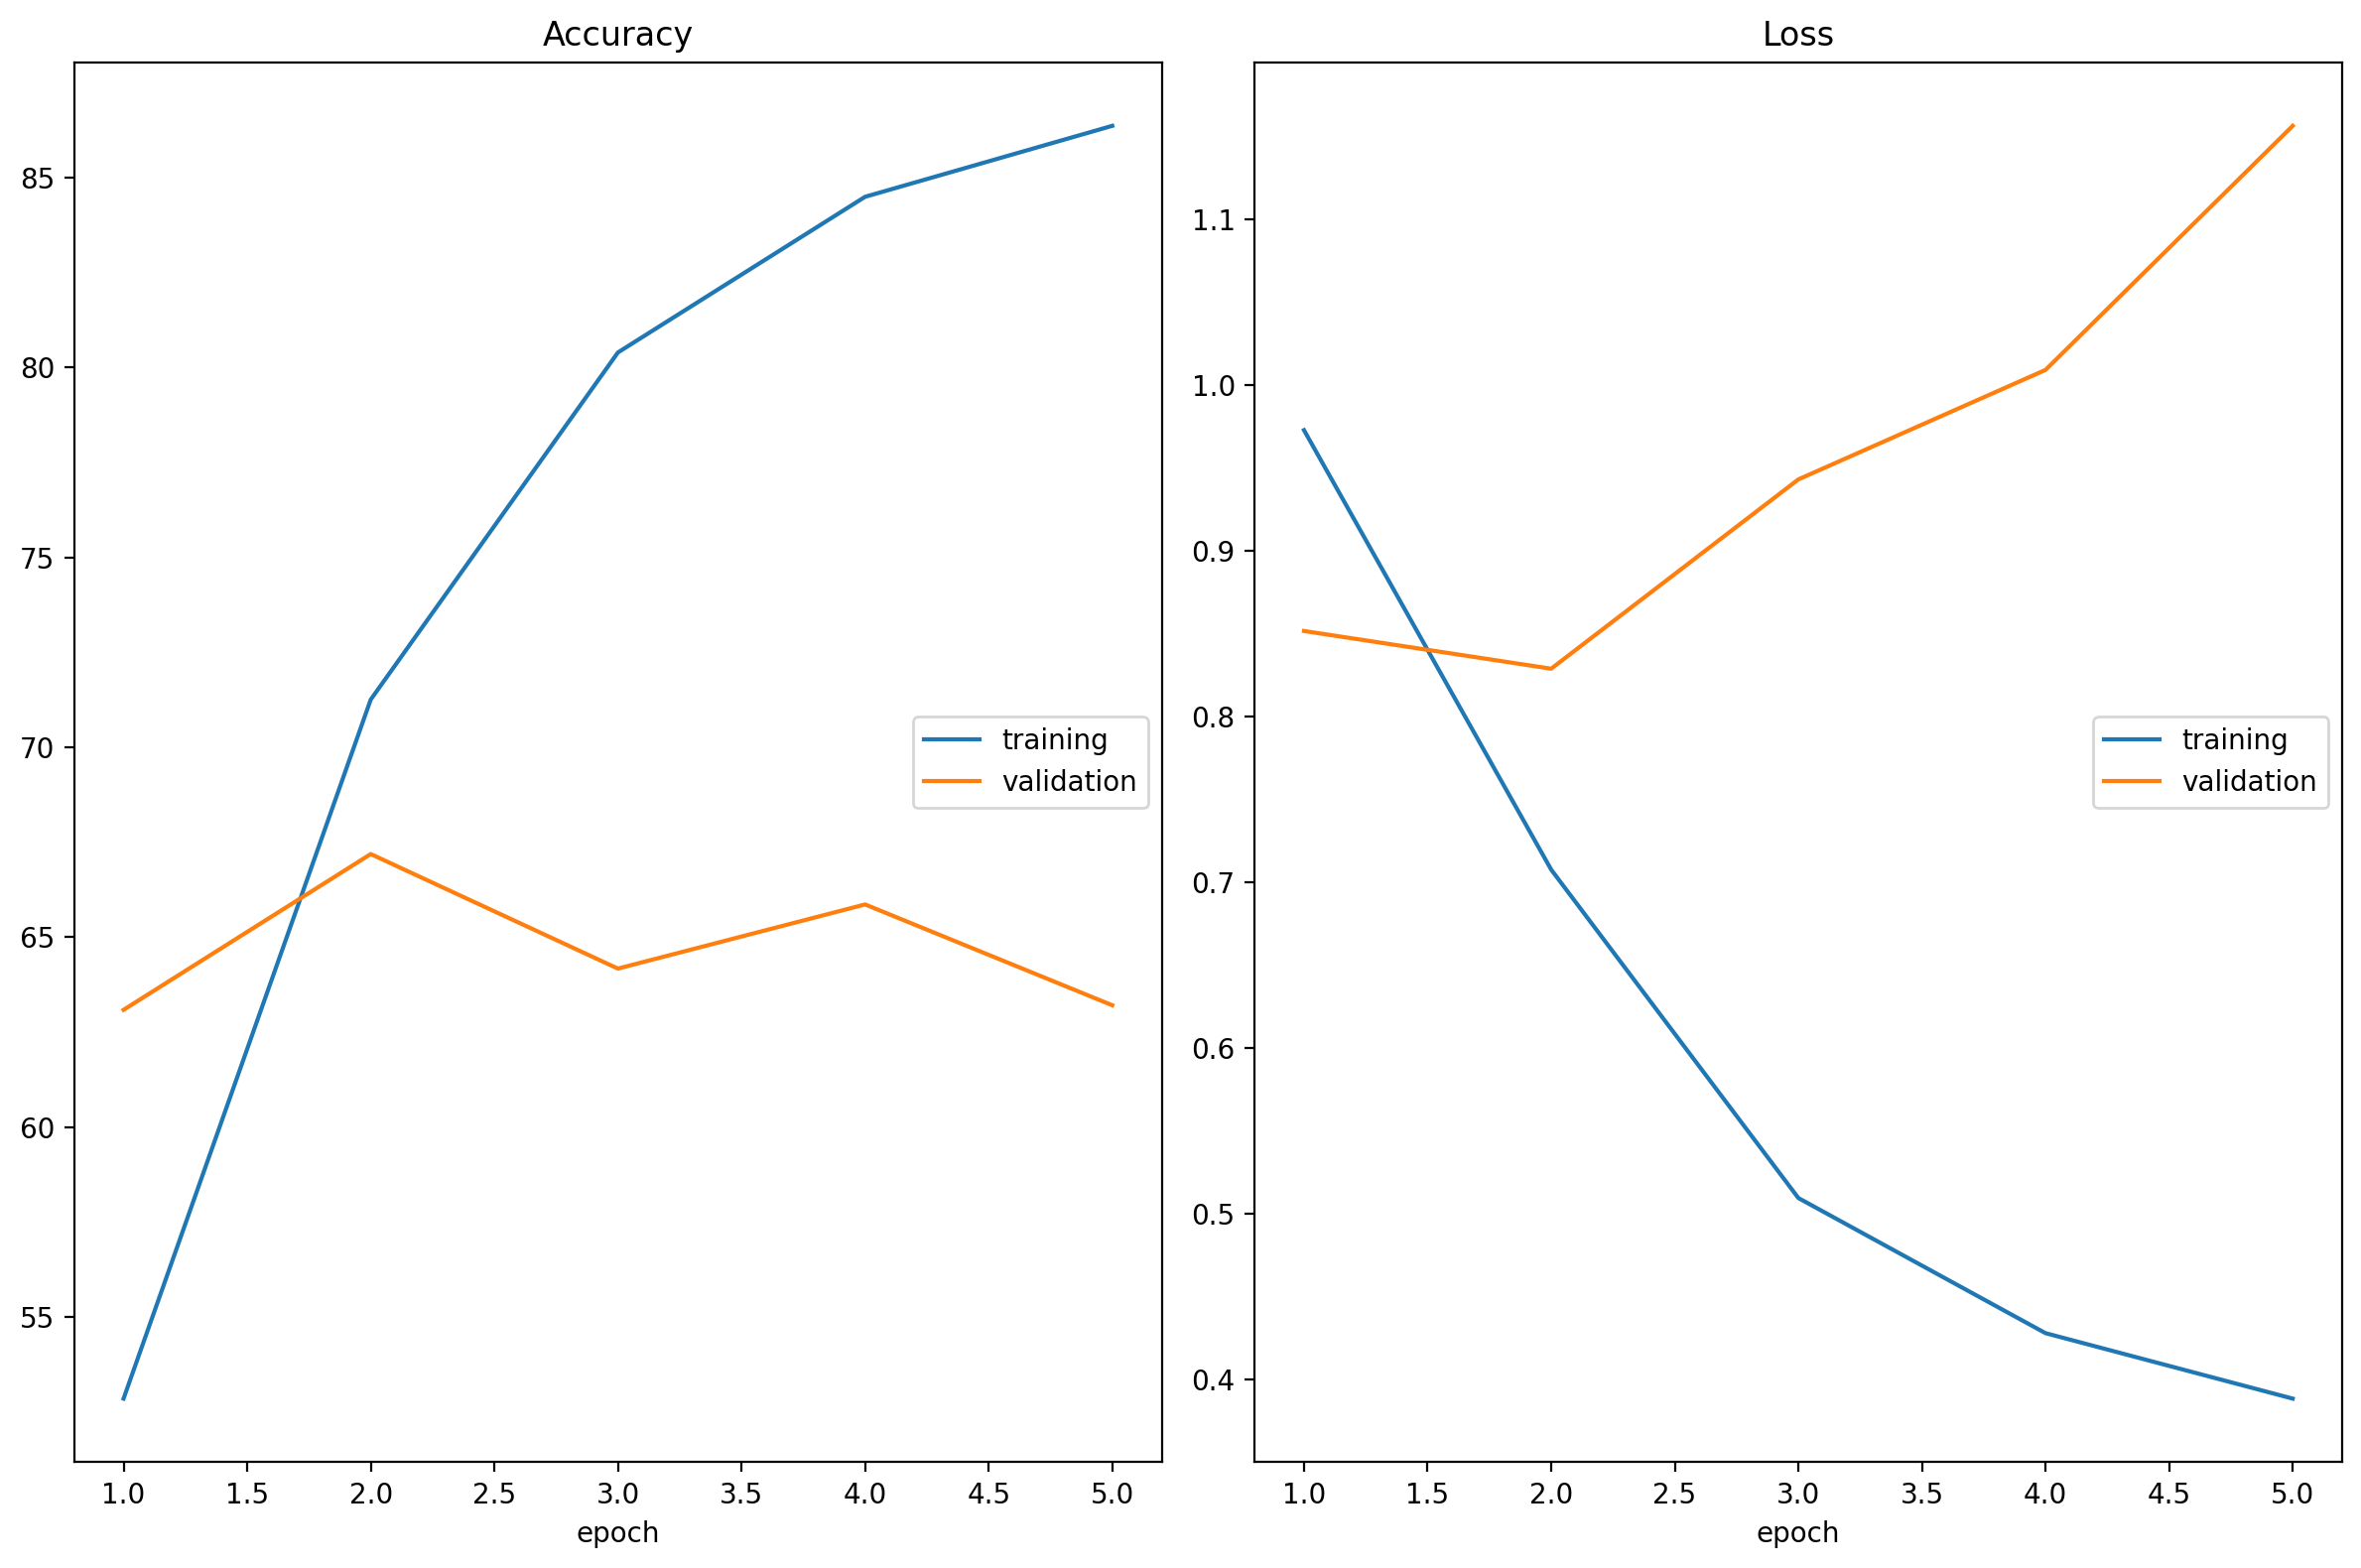

Accuracy
	training         	 (min:   52.853, max:   86.360, cur:   86.360)
	validation       	 (min:   63.088, max:   67.189, cur:   63.209)
Loss
	training         	 (min:    0.388, max:    0.972, cur:    0.388)
	validation       	 (min:    0.829, max:    1.156, cur:    1.156)
training time in minutes: 
10.804942708333334
Test steps: 104 2.34s test_loss: 0.828550 test_acc: 67.189385                                                  


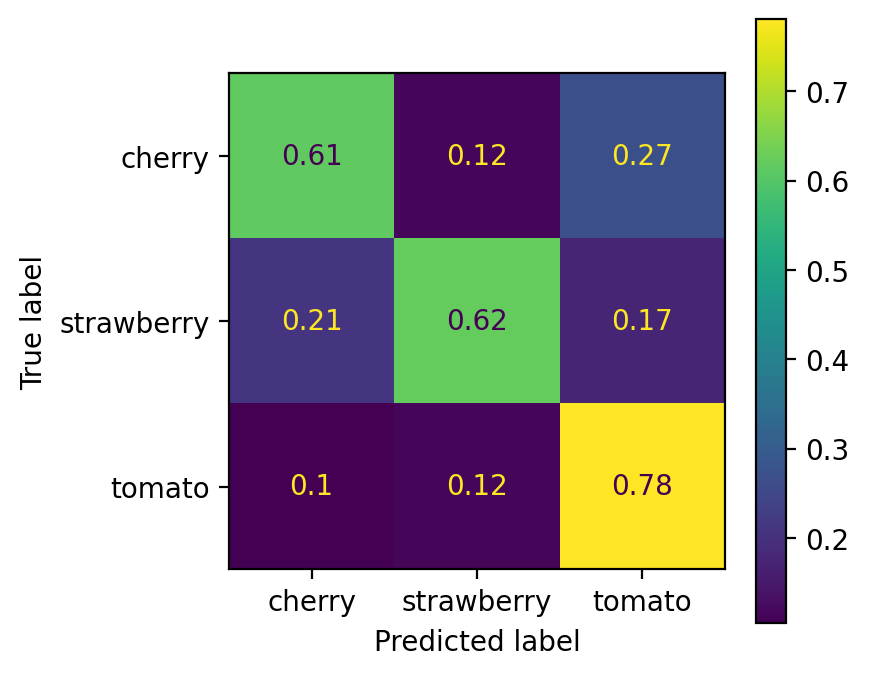

In [29]:
#net = Net().to(device)
net.load_state_dict(torch.load(PATHempty))
epochs=10
trainloader = DataLoader(increased_dataset, sampler=train_sampler, batch_size=8, shuffle=False,pin_memory=True)
valloader = DataLoader(increased_dataset, sampler=valid_sampler, batch_size=8, shuffle=False,pin_memory=True)
better_poutyne_train("trial1c",net,0.001)
PATH = './myownLR001.pth'
torch.save(net.state_dict(), PATH)

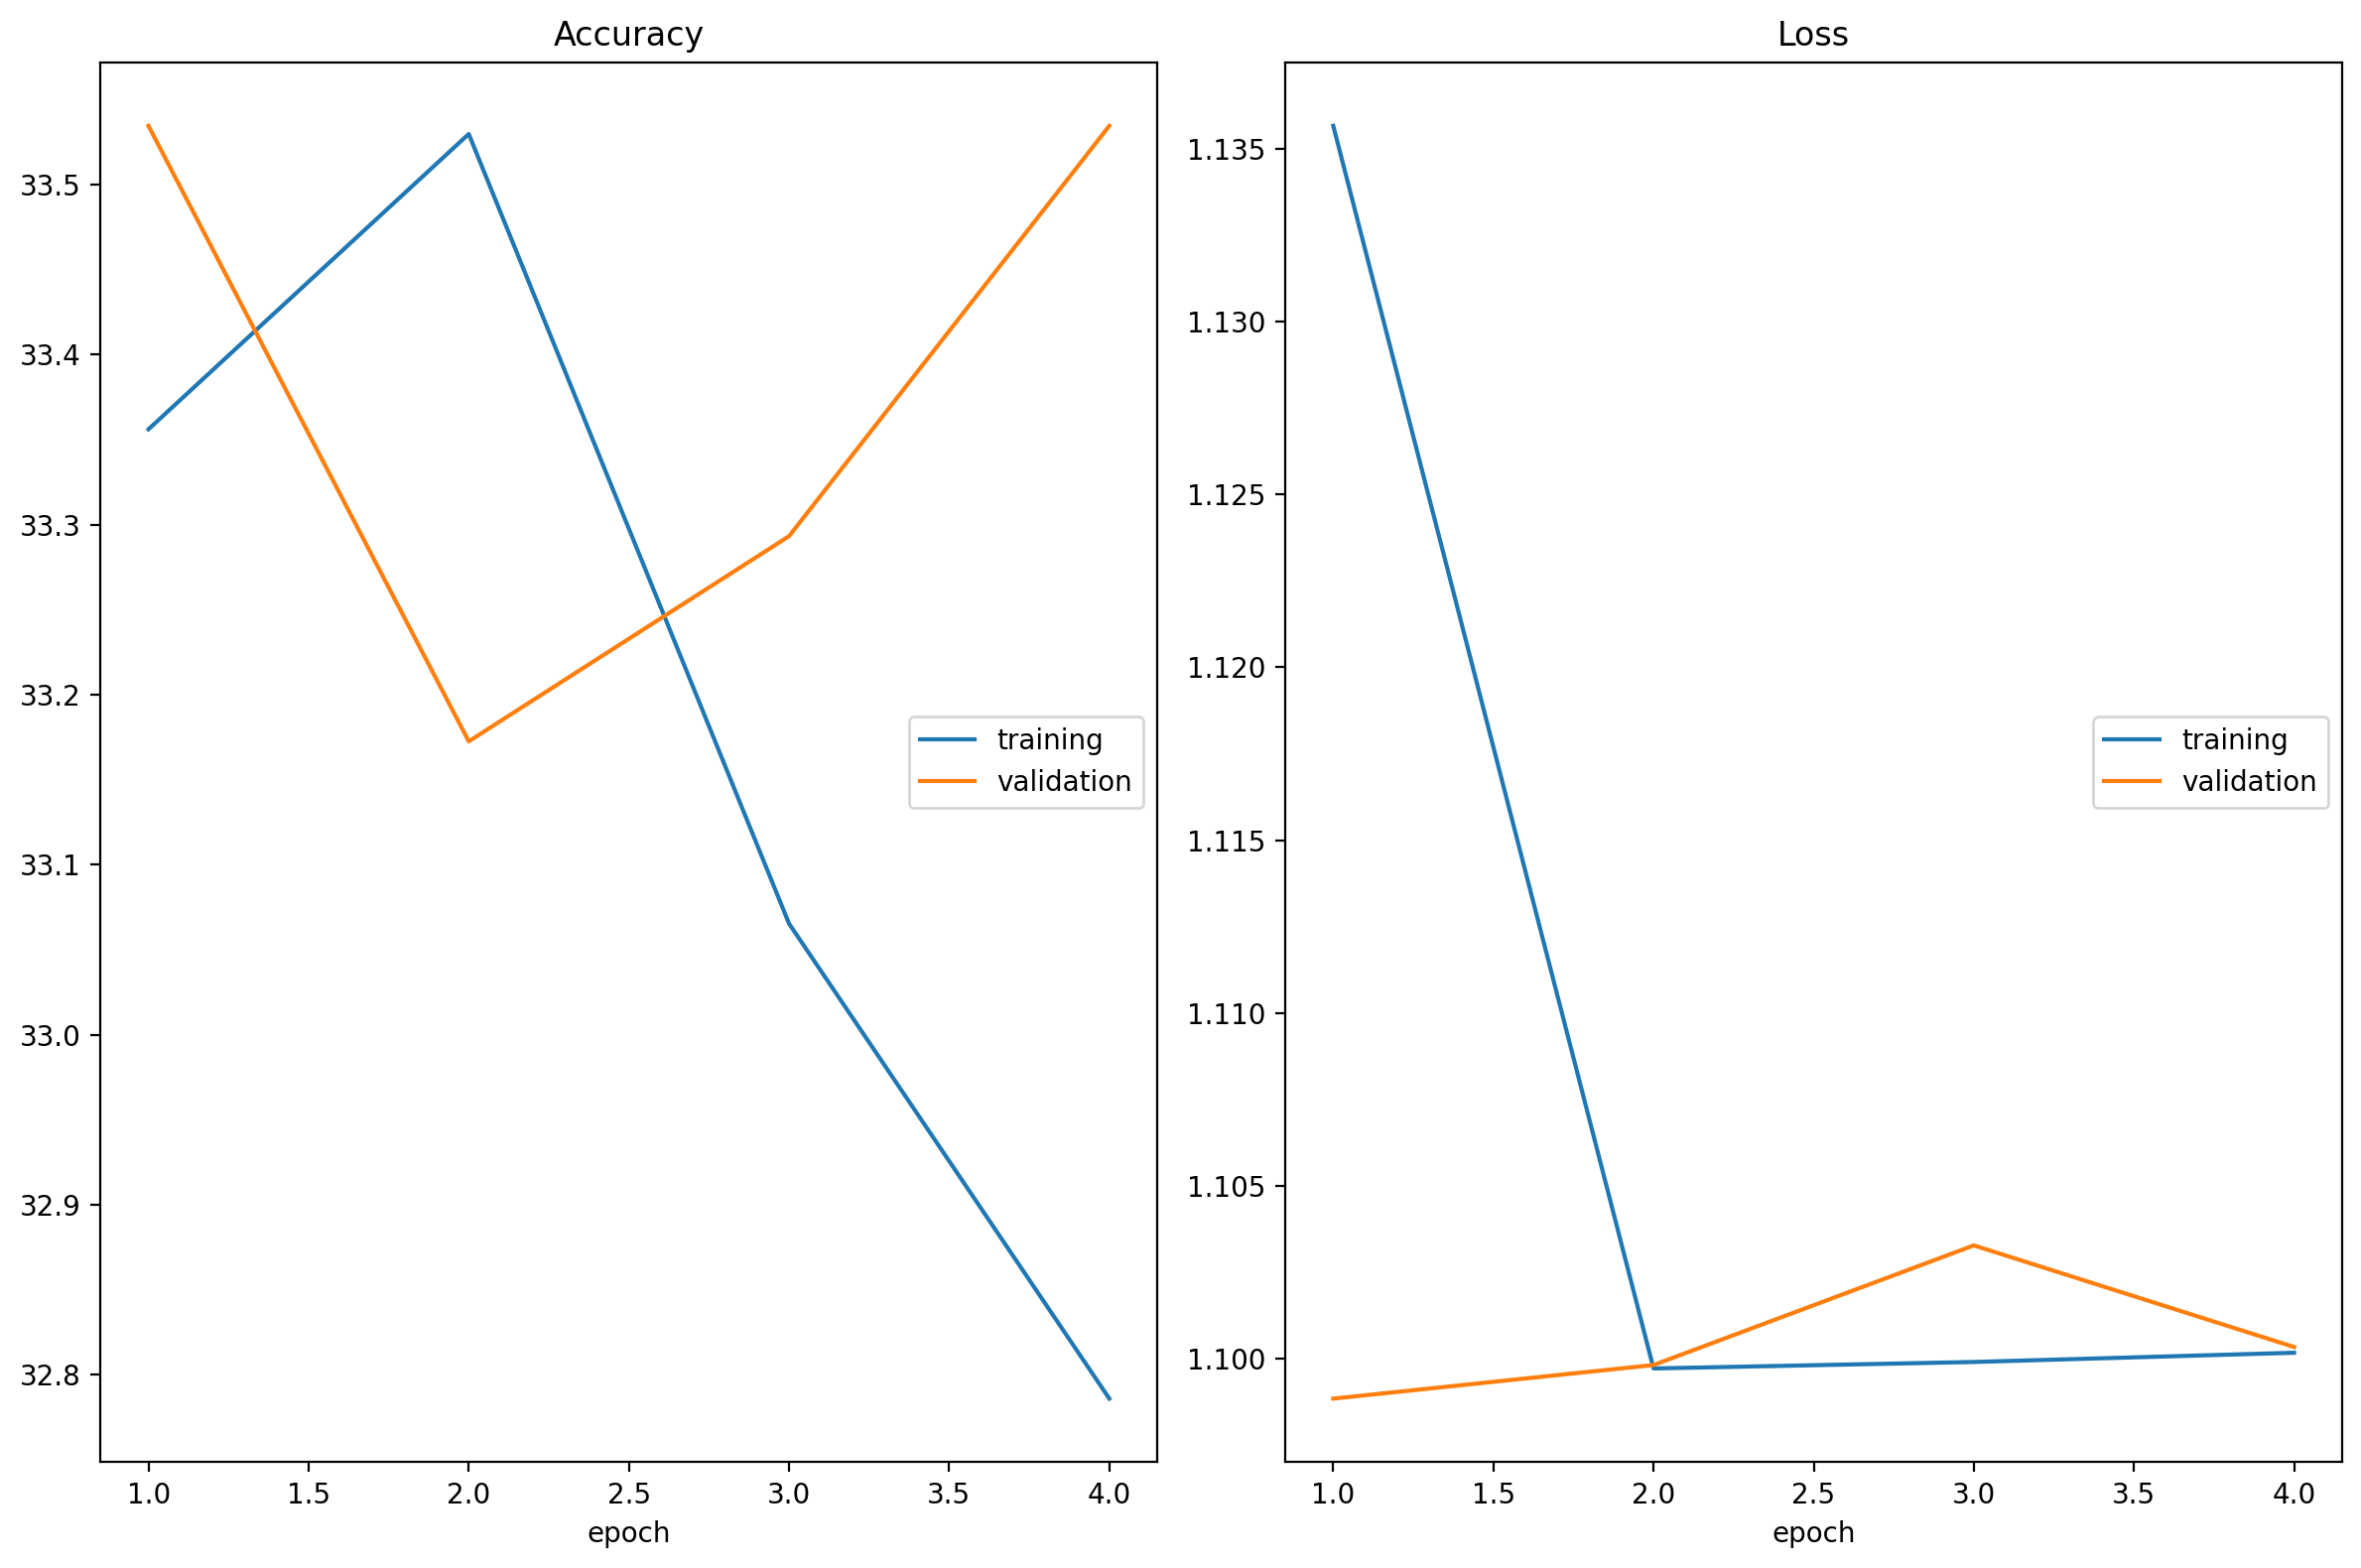

Accuracy
	training         	 (min:   32.786, max:   33.530, cur:   32.786)
	validation       	 (min:   33.172, max:   33.534, cur:   33.534)
Loss
	training         	 (min:    1.100, max:    1.136, cur:    1.100)
	validation       	 (min:    1.099, max:    1.103, cur:    1.100)
training time in minutes: 
8.657652604166667
Test steps: 104 2.79s test_loss: 1.098851 test_acc: 33.534379                                                 


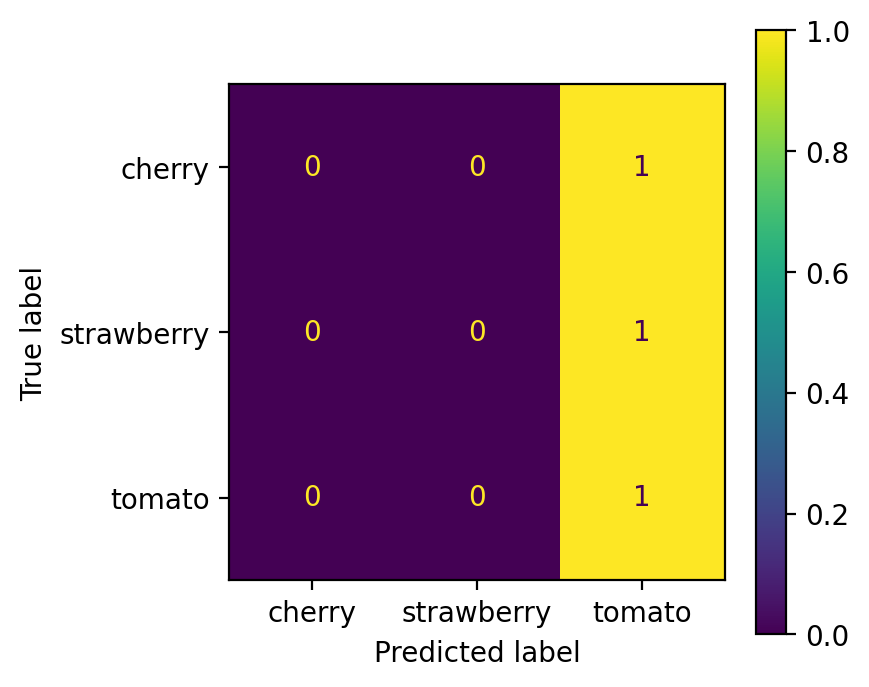

In [30]:
#net = Net().to(device)
net.load_state_dict(torch.load(PATHempty))
epochs=10
trainloader = DataLoader(increased_dataset, sampler=train_sampler, batch_size=8, shuffle=False,pin_memory=True)
valloader = DataLoader(increased_dataset, sampler=valid_sampler, batch_size=8, shuffle=False,pin_memory=True)
better_poutyne_train("trial1d",net,0.01)
PATH = './myownLR01.pth'
torch.save(net.state_dict(), PATH)

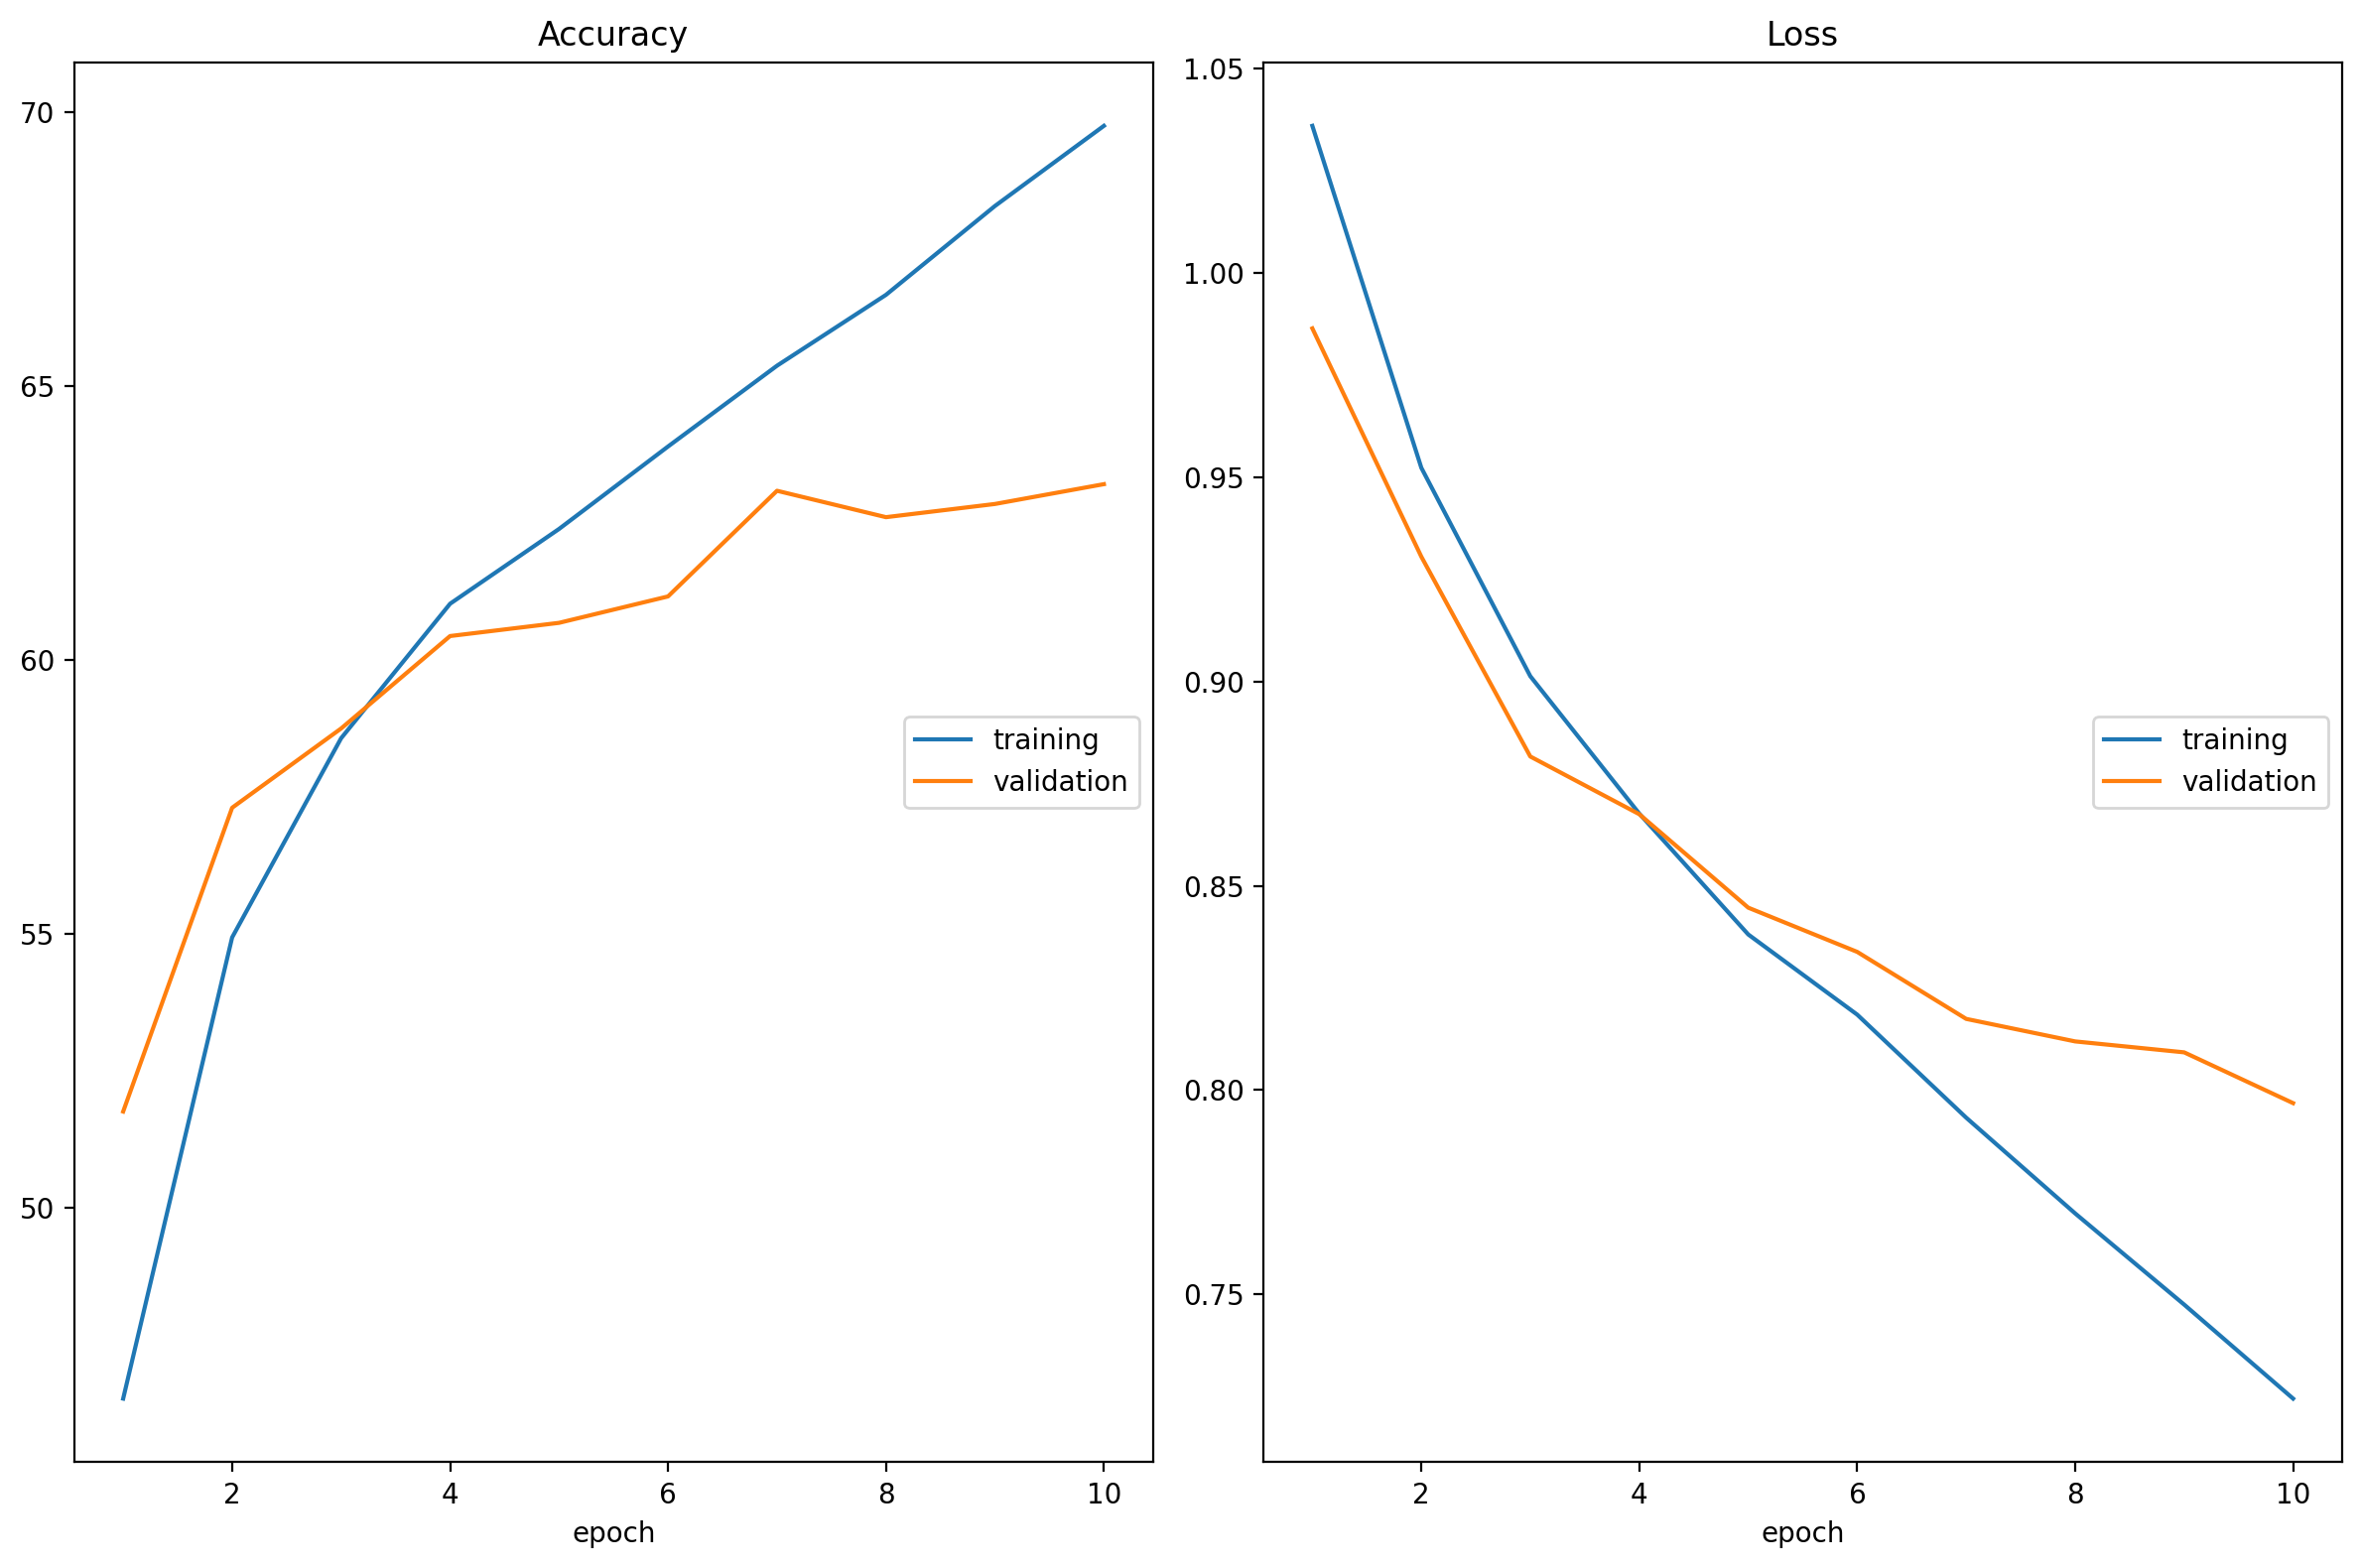

Accuracy
	training         	 (min:   46.505, max:   69.754, cur:   69.754)
	validation       	 (min:   51.749, max:   63.209, cur:   63.209)
Loss
	training         	 (min:    0.725, max:    1.036, cur:    0.725)
	validation       	 (min:    0.797, max:    0.986, cur:    0.797)
training time in minutes: 
21.646945833333334
Test steps: 104 2.28s test_loss: 0.796815 test_acc: 63.208685                                                 


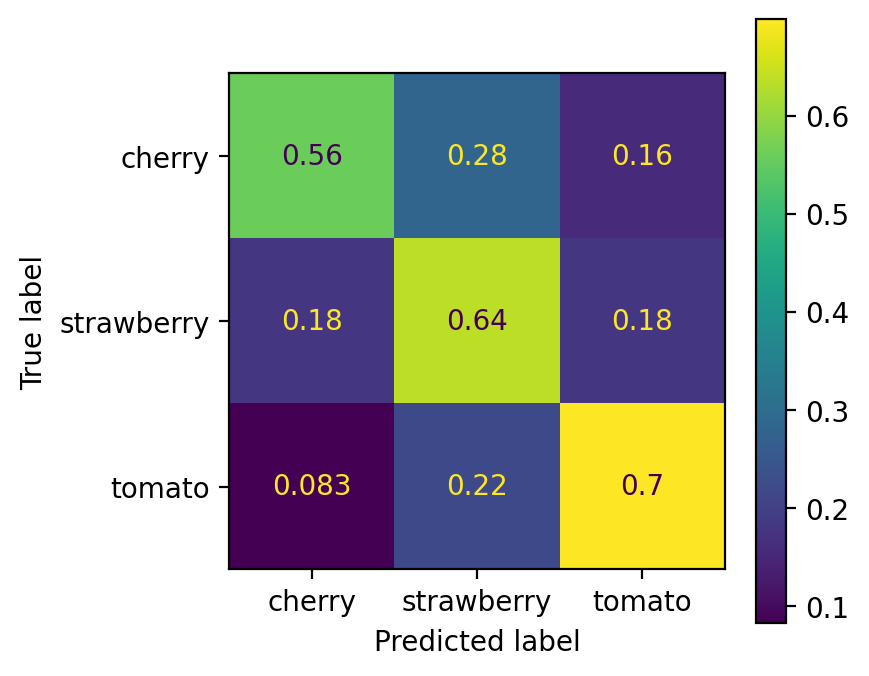

In [31]:
#net = Net().to(device)
net.load_state_dict(torch.load(PATHempty))
epochs=10
trainloader = DataLoader(increased_dataset, sampler=train_sampler, batch_size=8, shuffle=False,pin_memory=True)
valloader = DataLoader(increased_dataset, sampler=valid_sampler, batch_size=8, shuffle=False,pin_memory=True)
better_poutyne_train("trial1e",net,0.00001)
PATH = './myownLR00001.pth'
torch.save(net.state_dict(), PATH)

In [18]:
#net = Net().to(device)
#net.load_state_dict(torch.load(PATH))

In [19]:
from torchvision import models
def get_pretrained_model(model_name):
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), #nn.Dropout(0.2),
            nn.Linear(256, 3), nn.LogSoftmax(dim=1))
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(),
            nn.Linear(256, 3), nn.LogSoftmax(dim=1))

        model = model.to(device)

    return model



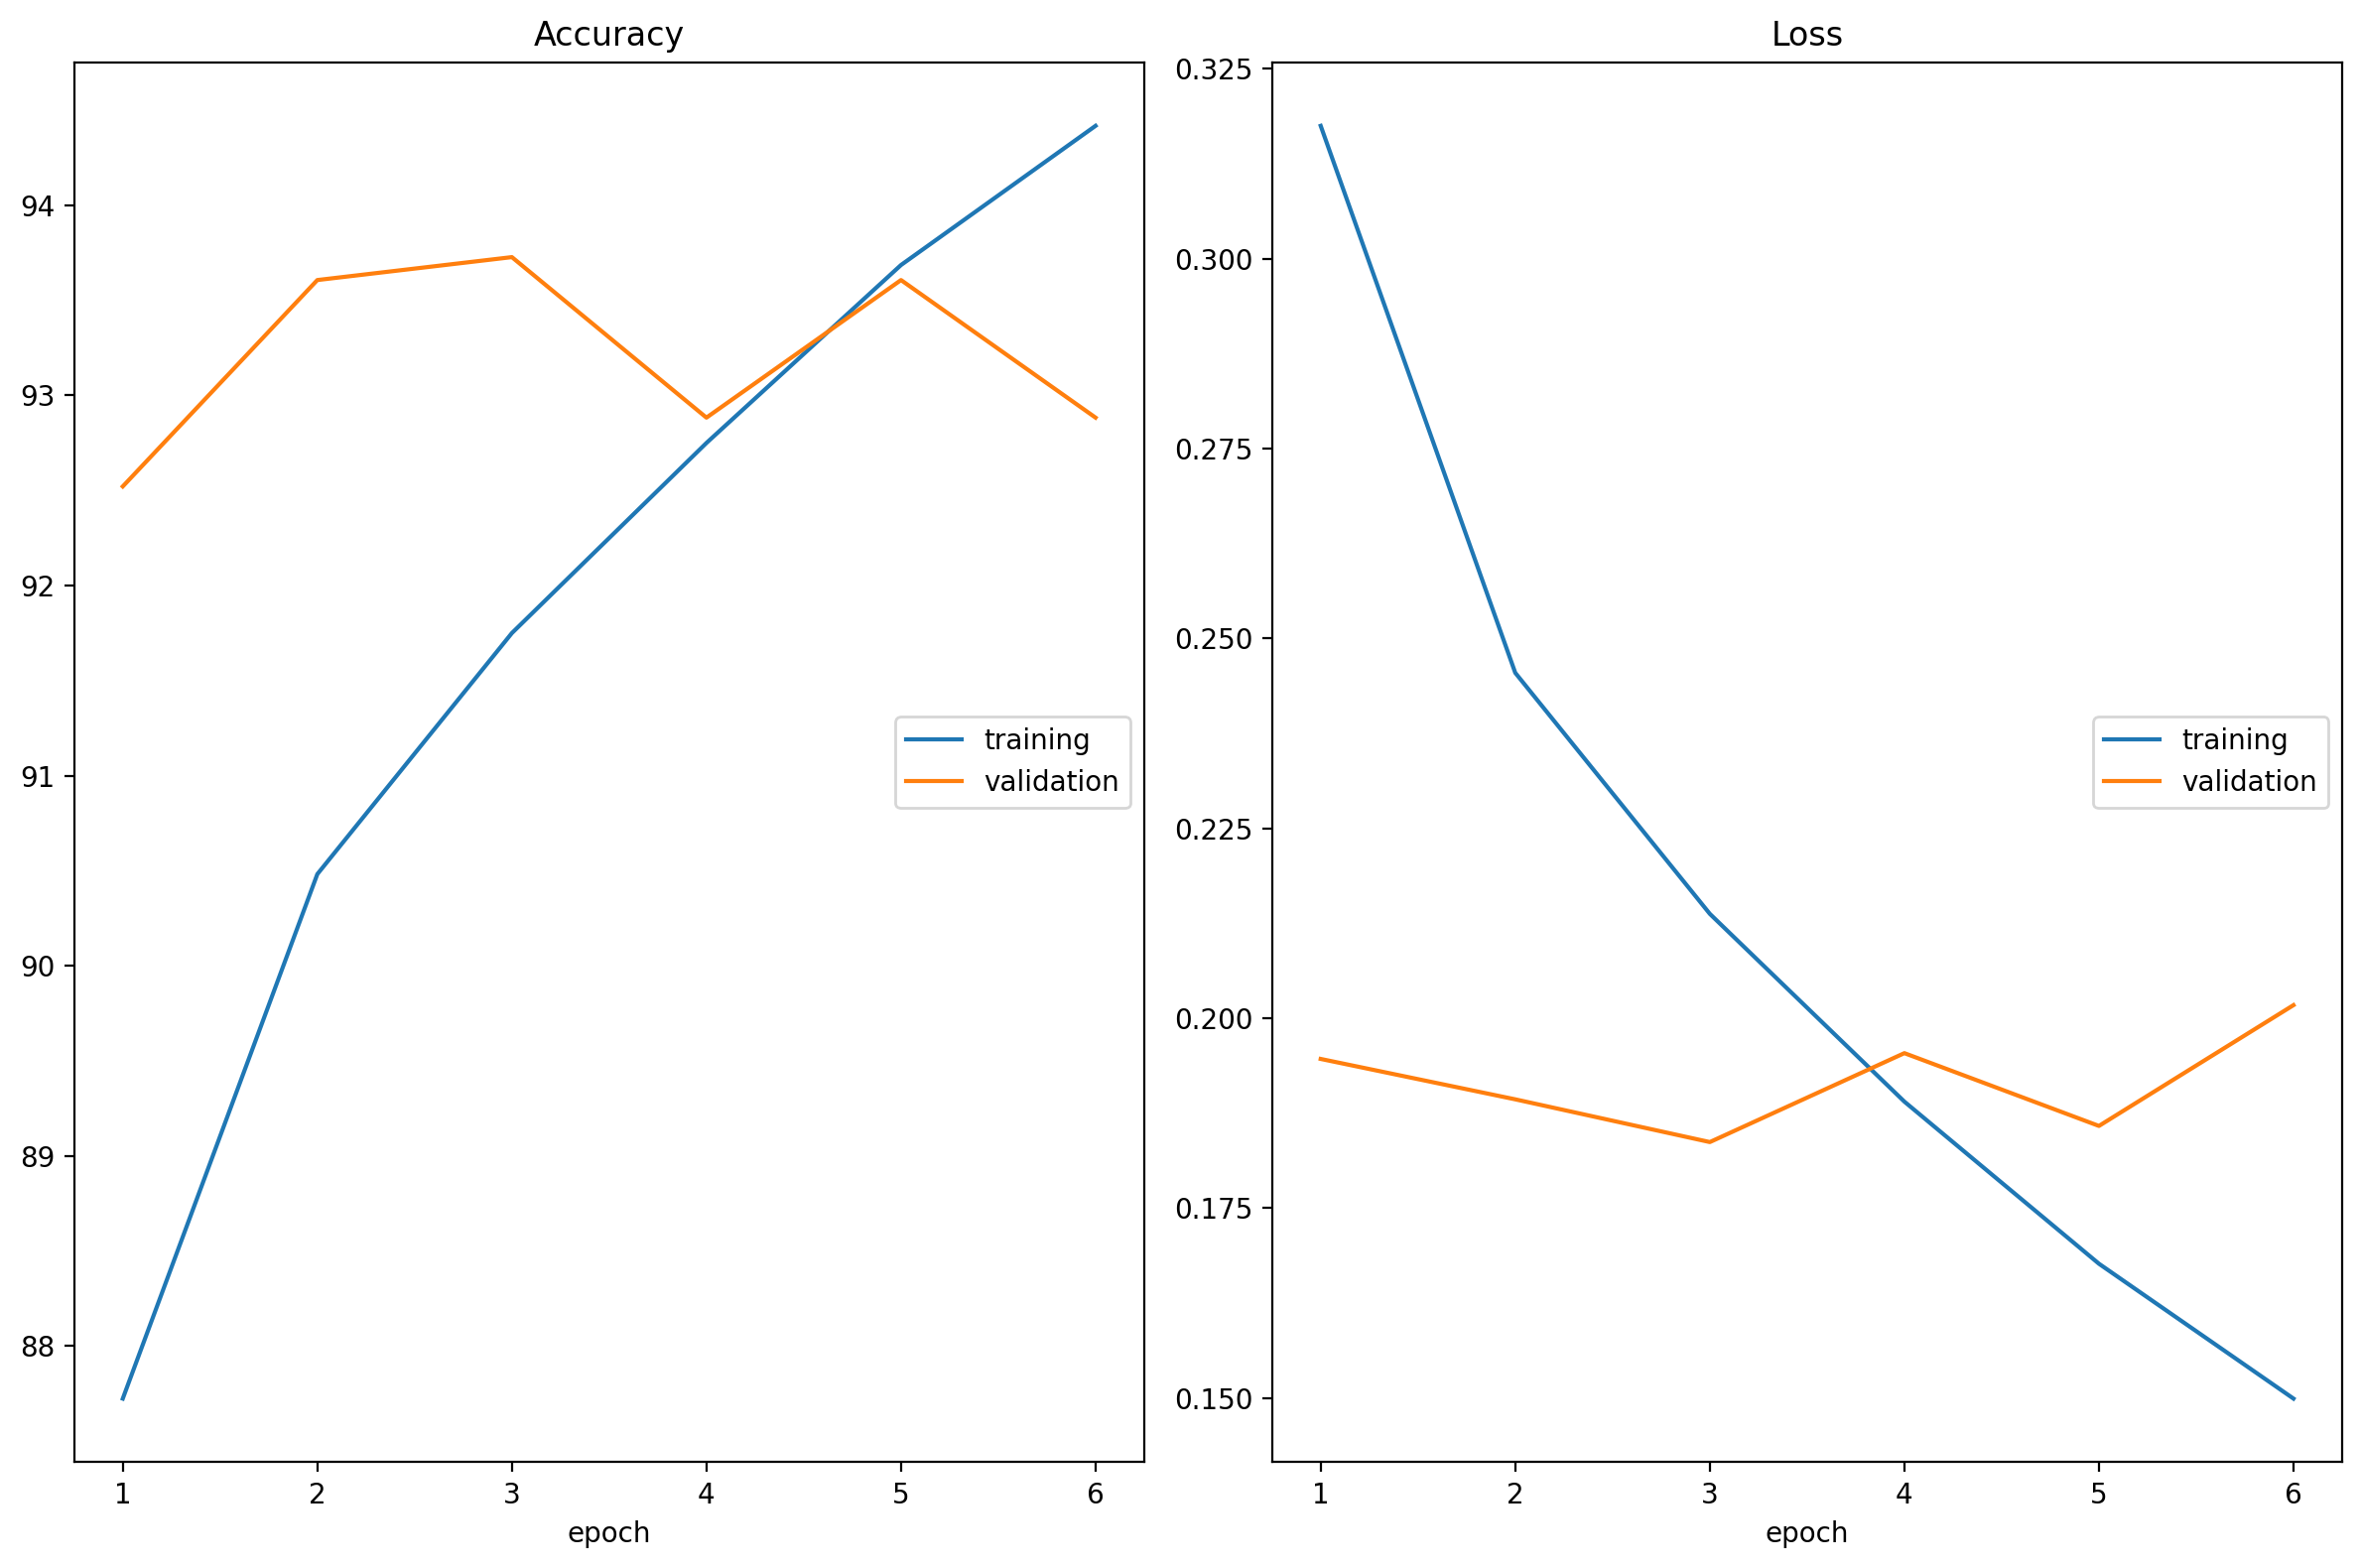

Accuracy
	training         	 (min:   87.723, max:   94.418, cur:   94.418)
	validation       	 (min:   92.521, max:   93.727, cur:   92.883)
Loss
	training         	 (min:    0.150, max:    0.317, cur:    0.150)
	validation       	 (min:    0.184, max:    0.202, cur:    0.202)
training time in minutes: 
39.775620833333335
Test steps: 104 11.30s test_loss: 0.183695 test_acc: 93.727382                                                  


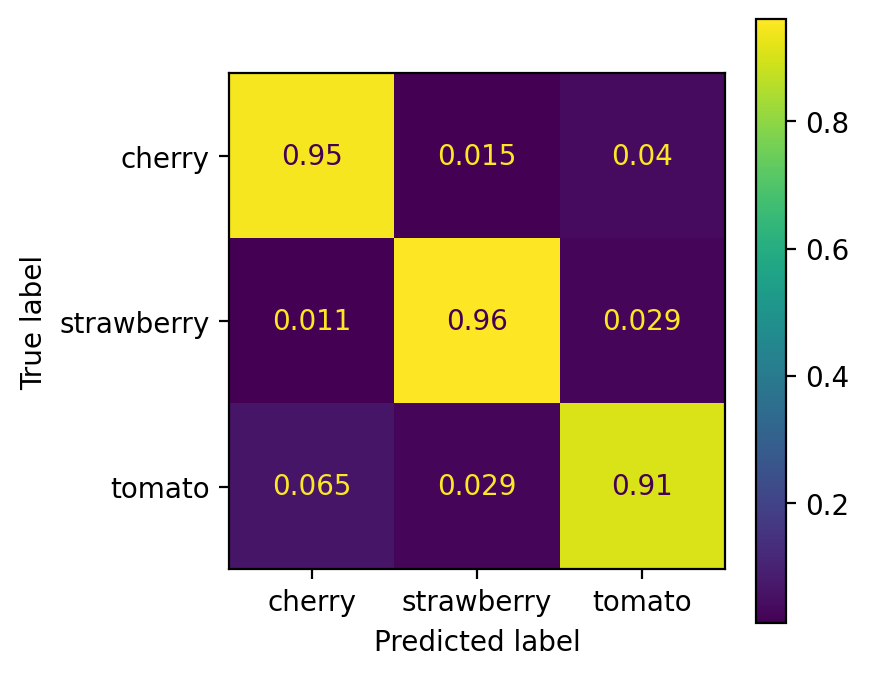

In [20]:
vgg16model = get_pretrained_model('vgg16')
better_poutyne_train("trial2",vgg16model)

In [21]:
PATH = './vgg16model.pth'
torch.save(vgg16model.state_dict(), PATH)

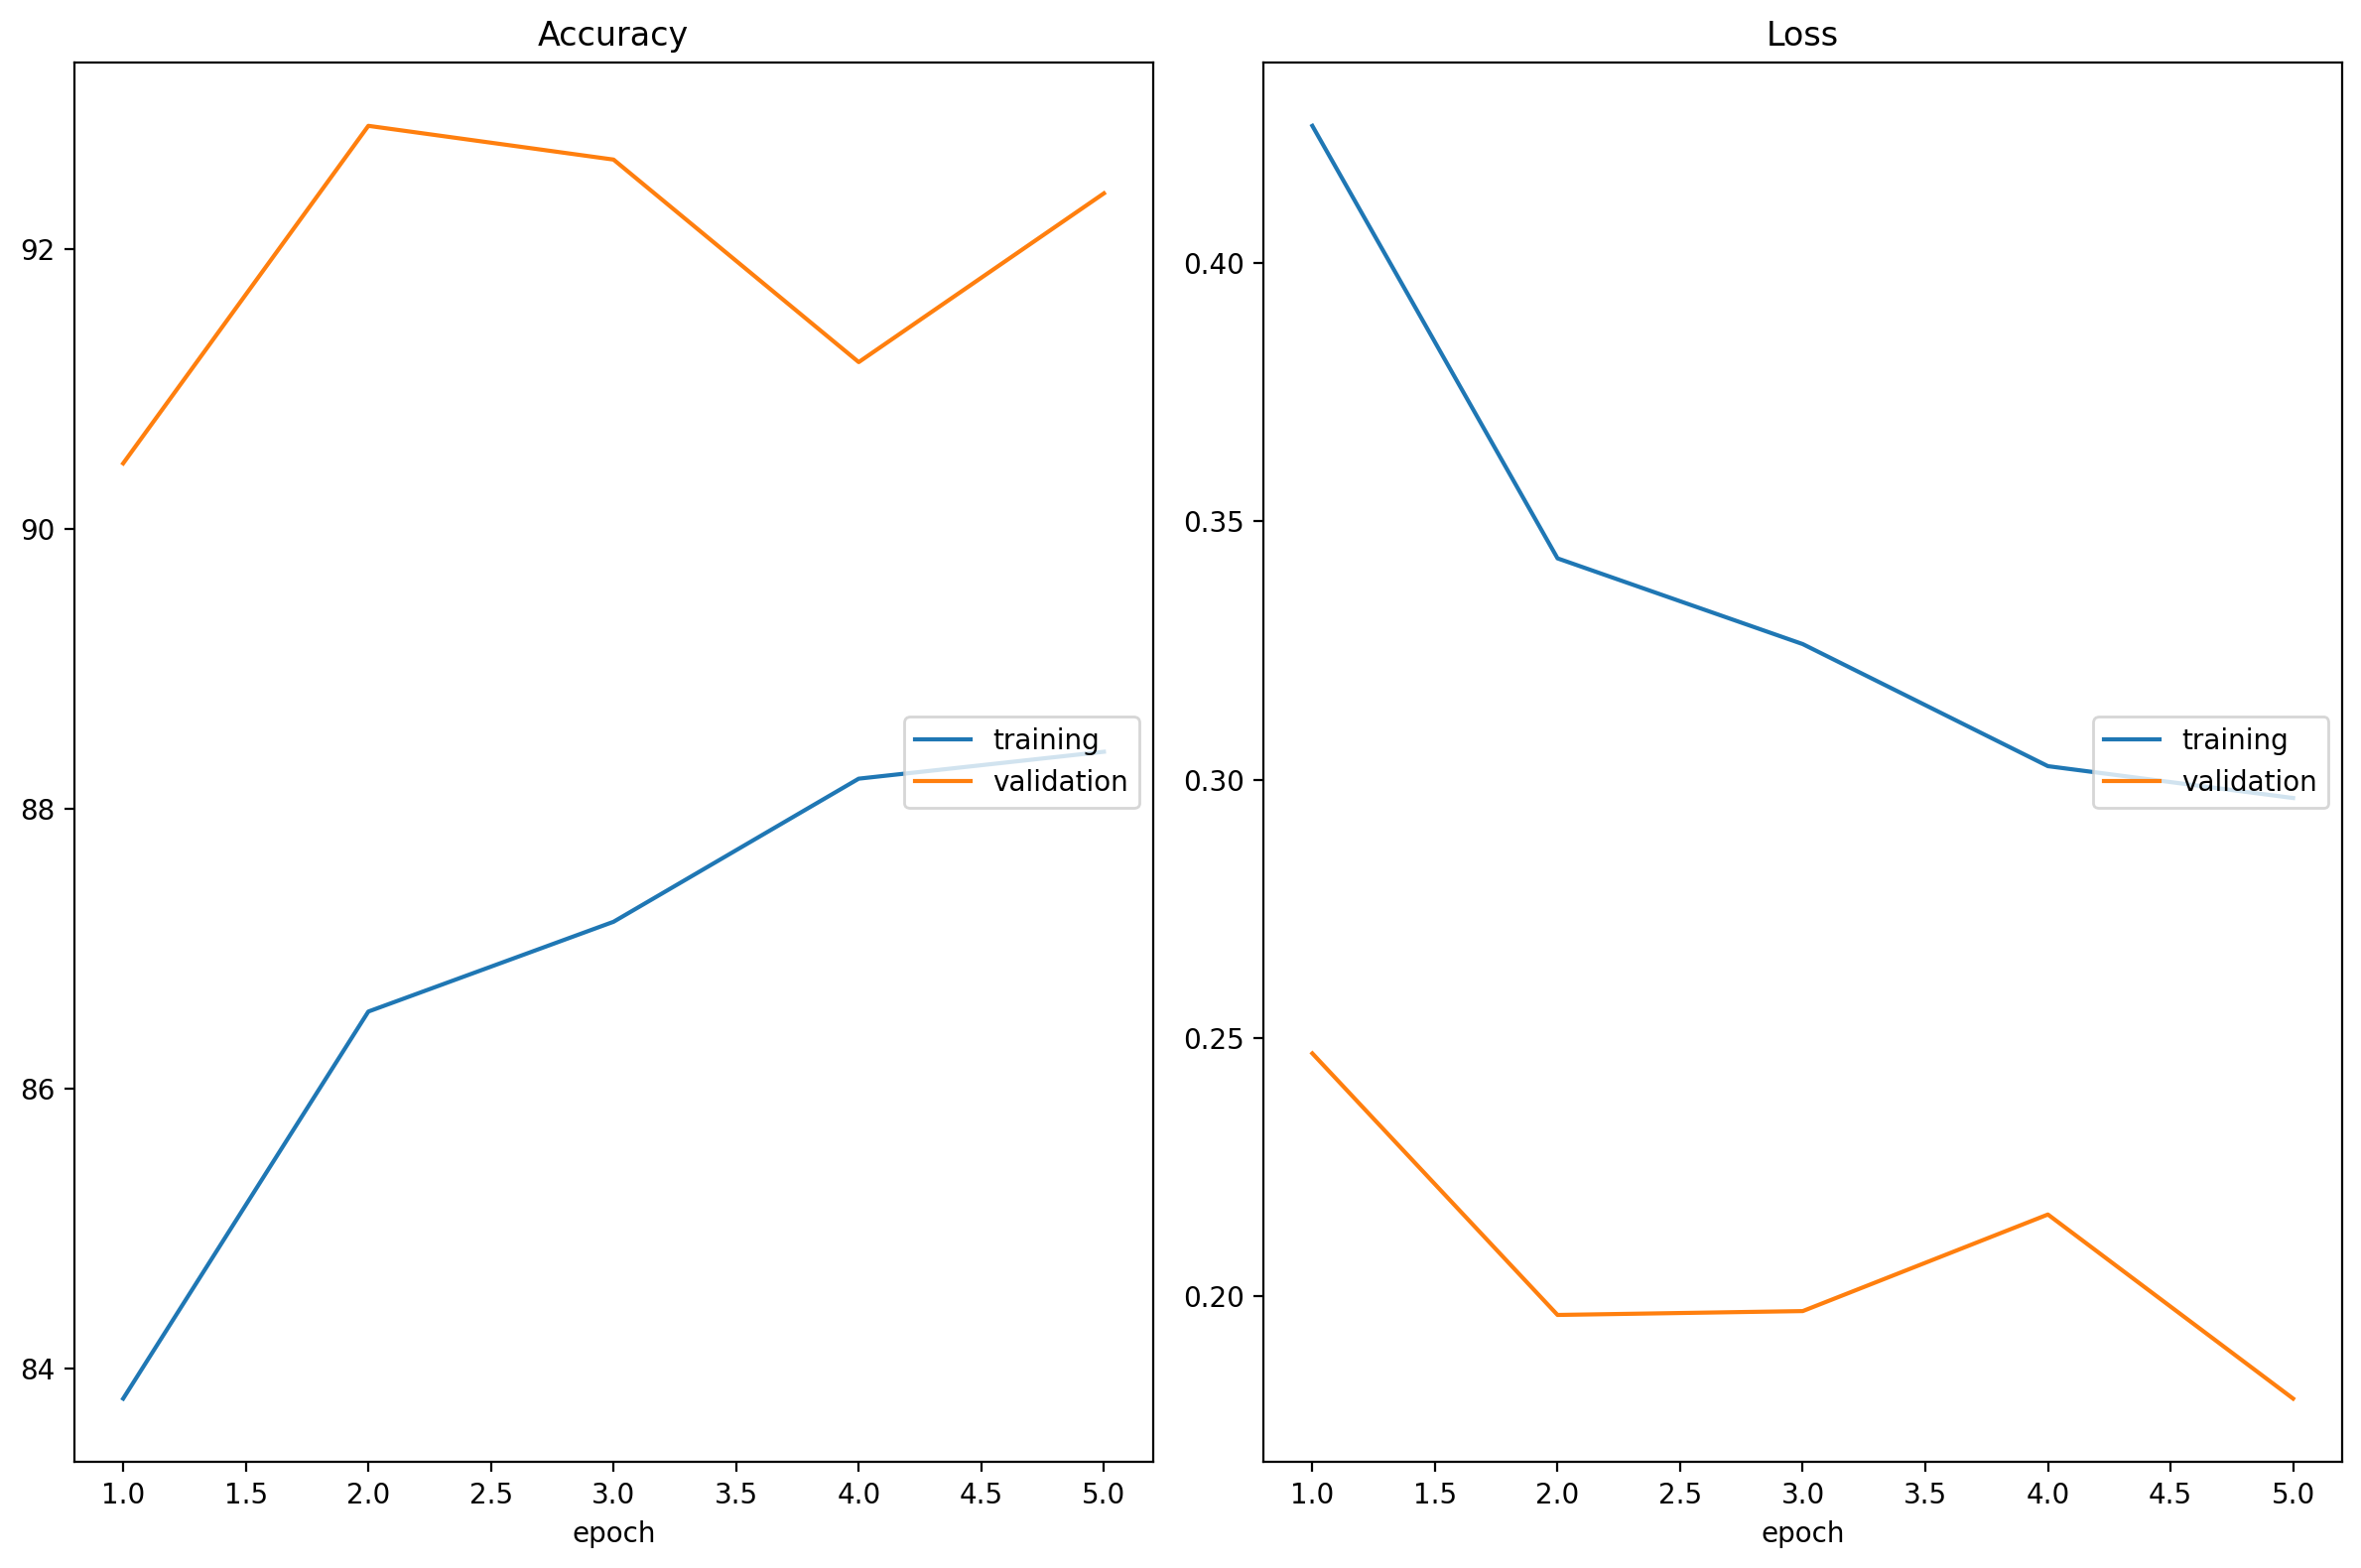

Accuracy
	training         	 (min:   83.786, max:   88.410, cur:   88.410)
	validation       	 (min:   90.470, max:   92.883, cur:   92.400)
Loss
	training         	 (min:    0.296, max:    0.427, cur:    0.296)
	validation       	 (min:    0.180, max:    0.247, cur:    0.180)
training time in minutes: 
20.478822916666665
Test steps: 104 6.42s test_loss: 0.196426 test_acc: 92.882992                                                  


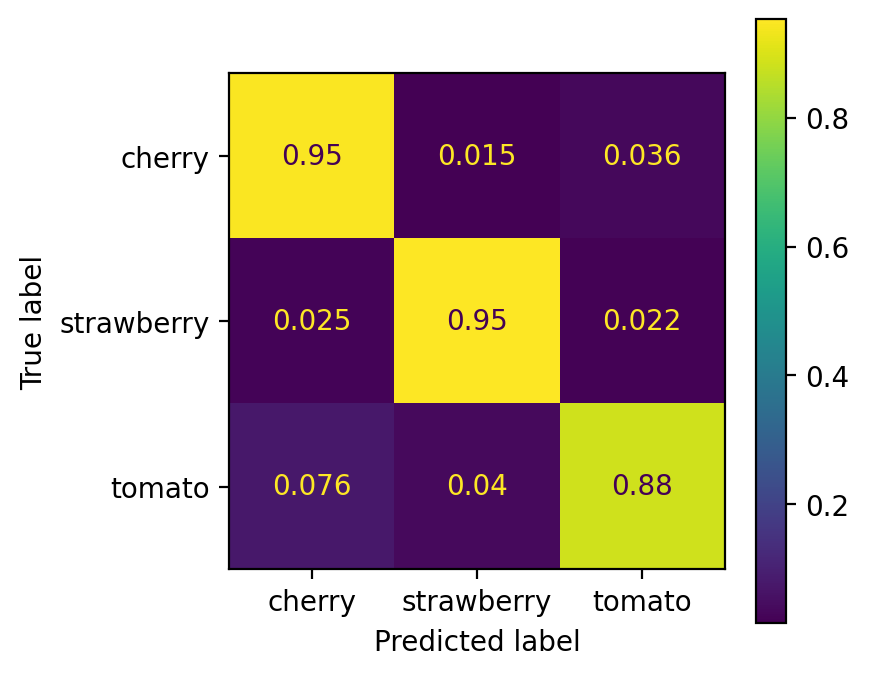

In [22]:
resnet50model = get_pretrained_model('resnet50')
summary(model=resnet50model, input_size=(3,300*300), batch_size=8) 

better_poutyne_train("trial3",resnet50model)


In [23]:
PATH = './resnet50model.pth'
torch.save(resnet50model.state_dict(), PATH)

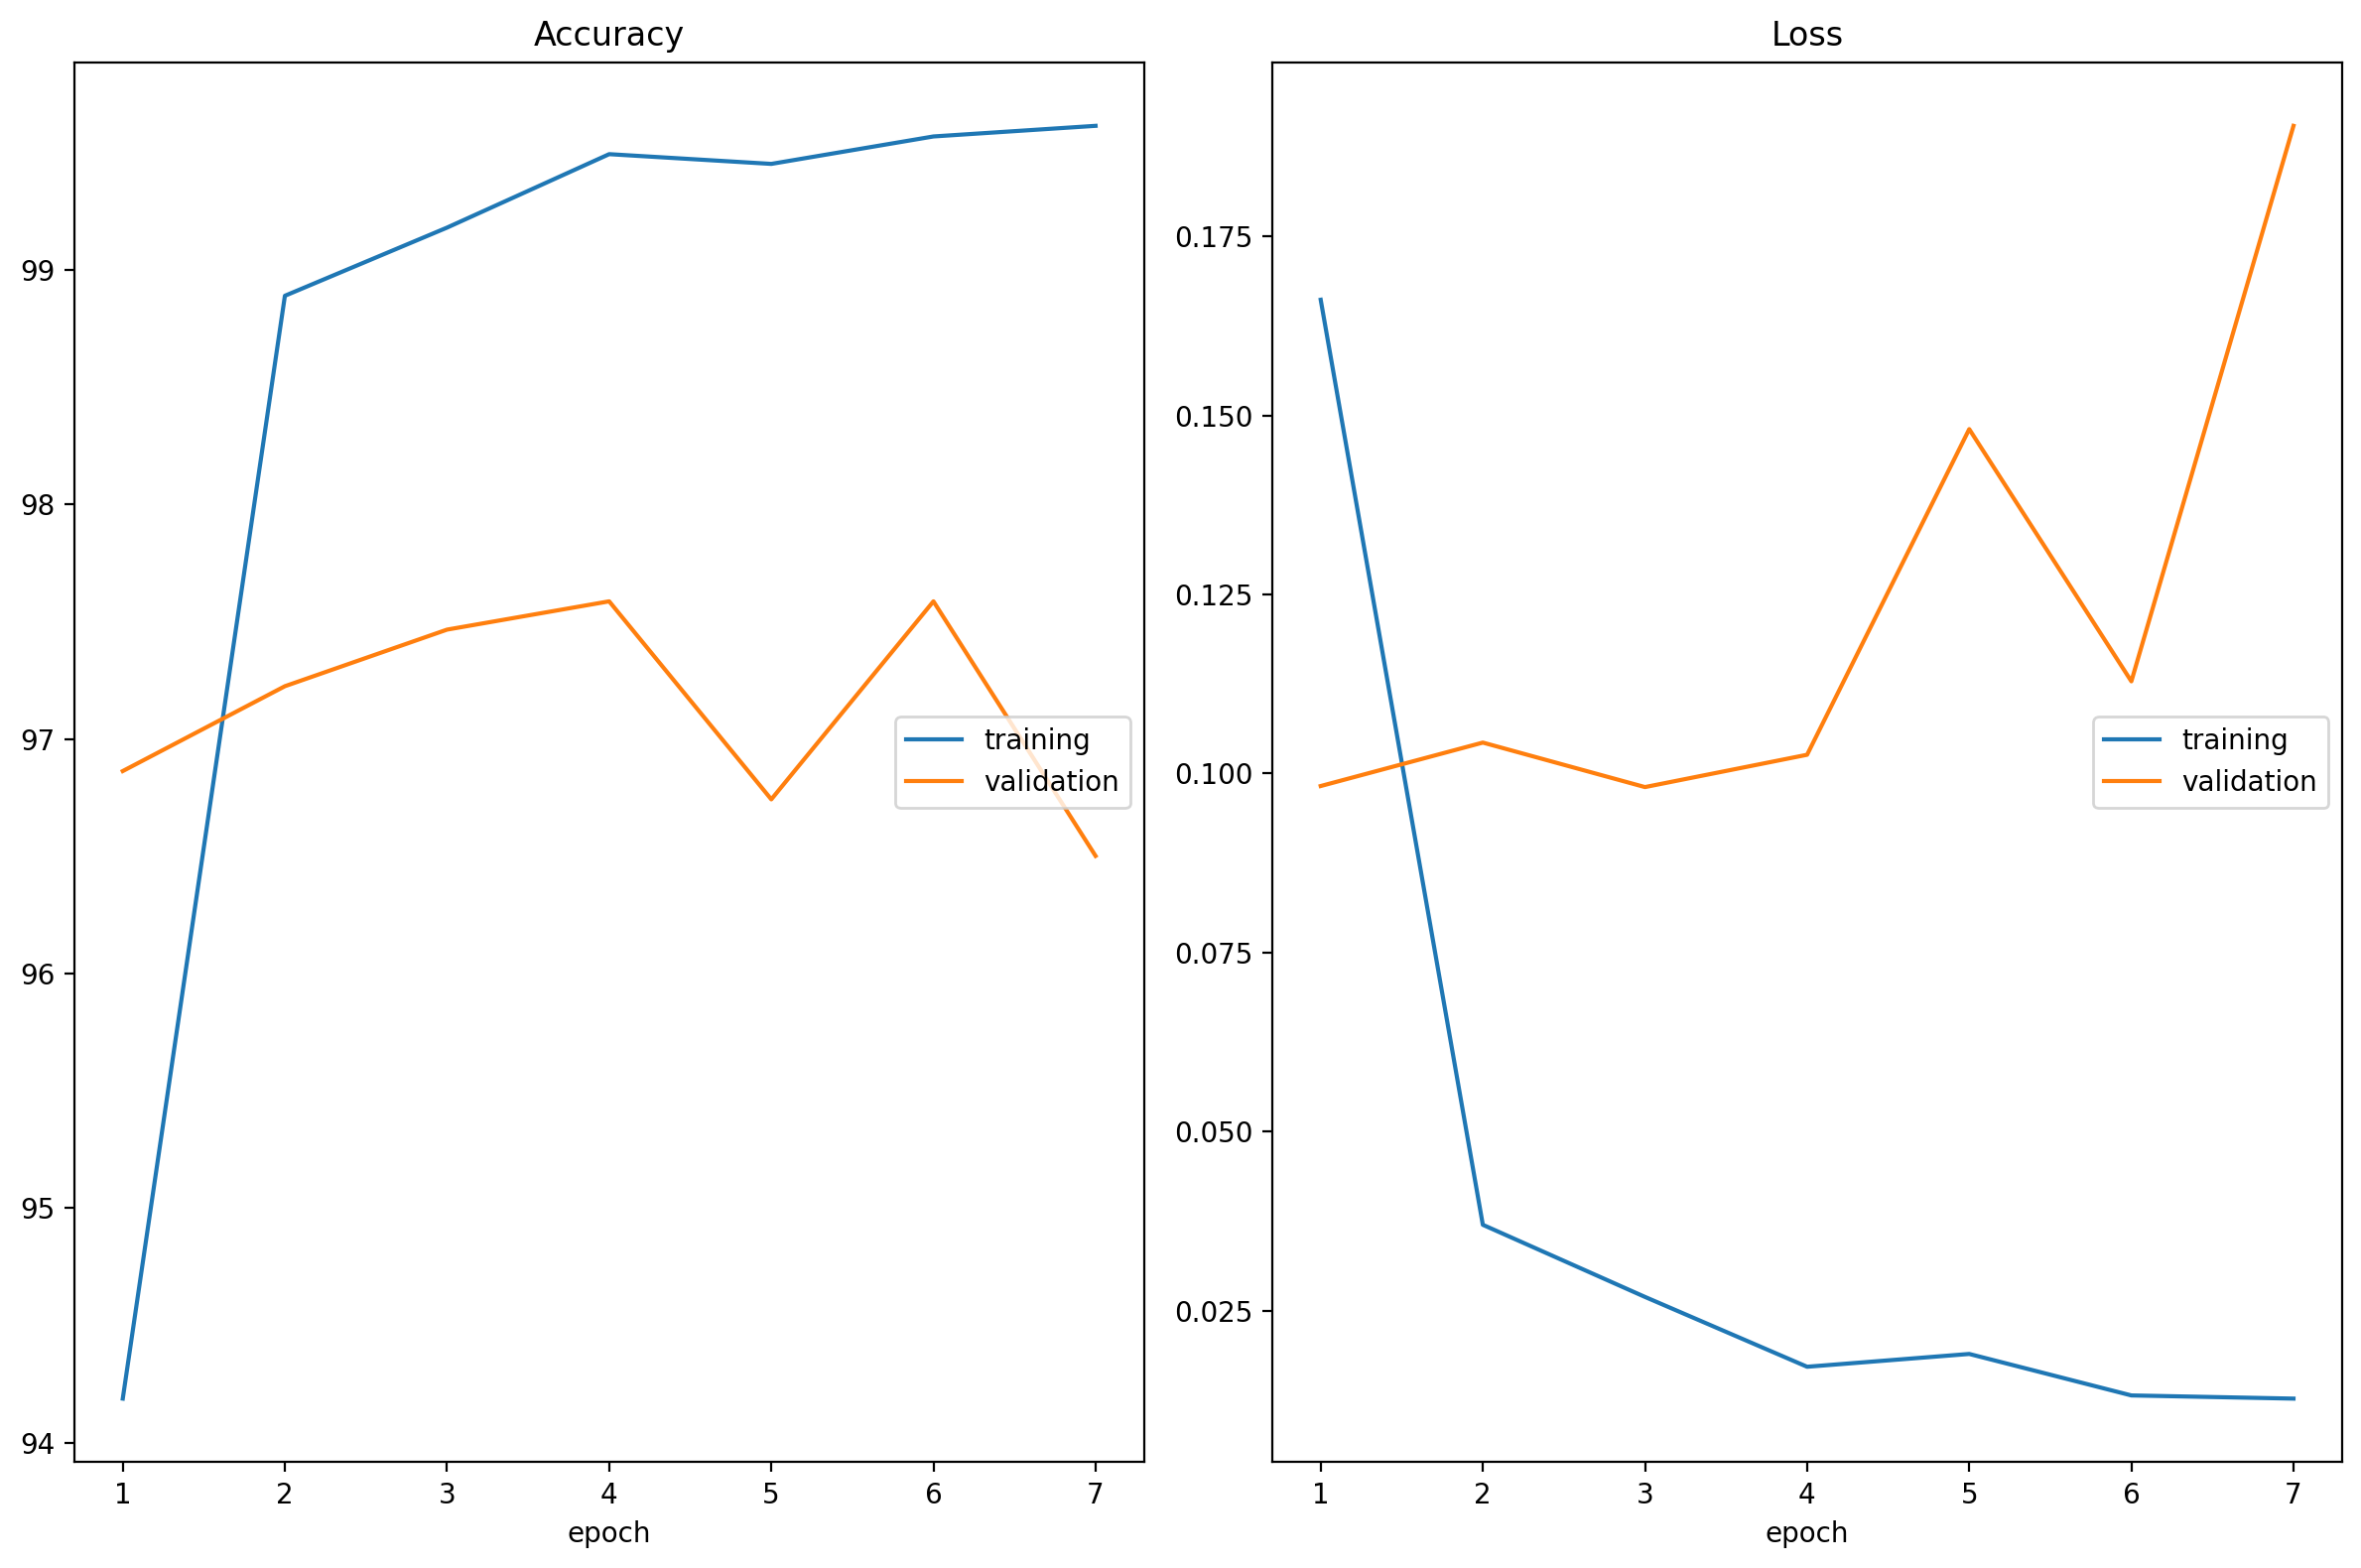

Accuracy
	training         	 (min:   94.188, max:   99.615, cur:   99.615)
	validation       	 (min:   96.502, max:   97.587, cur:   96.502)
Loss
	training         	 (min:    0.013, max:    0.166, cur:    0.013)
	validation       	 (min:    0.098, max:    0.190, cur:    0.190)
training time in minutes: 
73.52408333333334
Test steps: 104 6.06s test_loss: 0.102624 test_acc: 97.587455                                                  


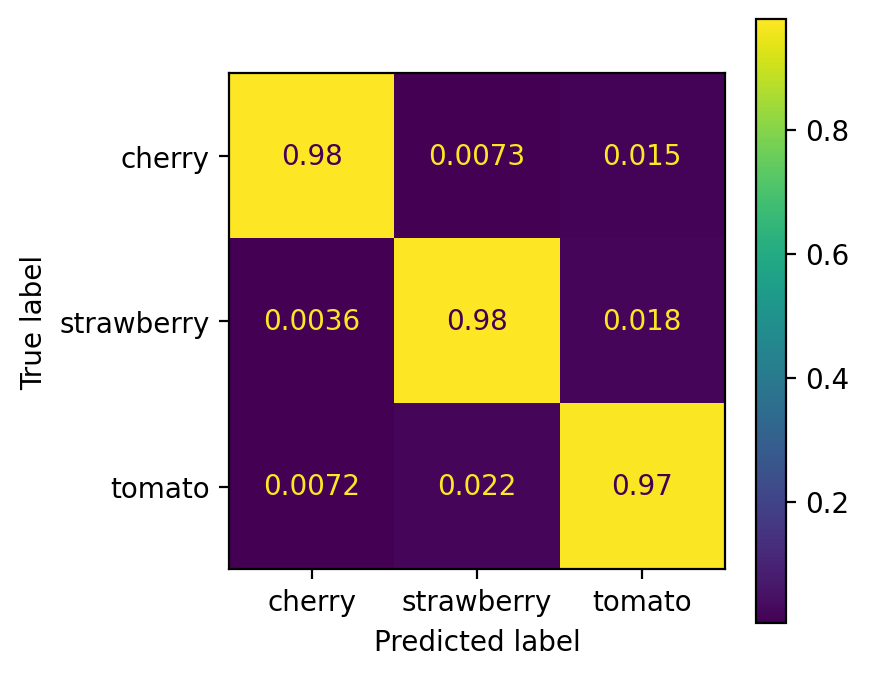

In [24]:
efficientnet = EfficientNet.from_pretrained('efficientnet-b2', num_classes=3)
summary(model=efficientnet, input_size=(3,300*300), batch_size=8) 

better_poutyne_train("trial4",efficientnet)

In [25]:
PATH = './efficientnet.pth'
torch.save(efficientnet.state_dict(), PATH)